<a href="https://colab.research.google.com/github/DataScientist13/stock-price-prediction/blob/main/Stock_Prediction_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Imports**

In [12]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import random
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import time
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout, TimeDistributed
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore", module="statsmodels")

### **Introduction**

In this project, we used machine learning techniques to predict stock prices using historical data from Yahoo Finance. We built two models: a Convolutional Neural Network (CNN) and a CNN-LSTM hybrid. The CNN focused on short-term patterns and achieved an R² of 0.89 with an MSE of 55.05 and MAE of 5.56. The CNN-LSTM captured both short- and long-term trends but performed worse with an R² of 0.602. We also used ARIMA to model linear trends and combined its residuals with XGBoost for further refinement. This ARIMA+XGBoost approach produced the best results, with an R² of 0.918, MSE of 1.64, and MAE of 0.79. While ARIMA+XGBoost is the most reliable for forecasting, CNN-based models provide useful insights into stock price patterns.
The models we've chosen fit the stock price prediction problem by leveraging their strengths in handling different aspects of time-series data.
1.	Convolutional Neural Network (CNN): CNNs are excellent at detecting patterns and trends in data. In the context of stock price prediction, they can identify important features from historical price data, such as recurring patterns or anomalies.
2.	CNN-LSTM Model: This hybrid model combines the pattern recognition capability of CNNs with the sequence-learning power of LSTMs. The CNN layers extract features from the data, while the LSTM layers capture the temporal dependencies and trends over time. This combination could be useful for predicting stock prices because it can learn both the spatial features and temporal dynamics of the data.
3.	ARIMA and XGBoost Integration: ARIMA models are effective for capturing linear trends and seasonality in time-series data, while XGBoost is a powerful machine learning model that can handle complex, non-linear relationships. Combining these models allows us to capture both linear and non-linear patterns, improving prediction accuracy.
For training these models, we'll use the Mean Squared Error (MSE) loss function. MSE measures the average squared difference between the predicted and actual values. It's a suitable choice because it penalizes larger errors more heavily, which is important in stock price prediction where accurate forecasting is crucial. By minimizing the MSE, the models will be optimized to make predictions as close to the actual stock prices as possible.
We also use MAE (Mean Absolute Error) that Computes the average absolute difference between predicted and actual values. and R2 measures to evaluate how well the predictions match the actual data.
Our models all will be tested on the data of 7 leading stocks (sometimes referred to as 'the magnificent seven'): Apple, Microsoft, Google, Nvidia, Tesla, Amazon, and Meta. These stocks are very popular and are characterized with a high volatility. We used 5 years of data (Jan 2019 - Dec 2023) from Yahoo Finance as our dataset.


### **Data Collection**

In [14]:
# Step 1: Download the data
def download_stock_data(ticker, start, end):
    stock_data = yf.download(ticker, start=start, end=end)
    return stock_data

# Step 2: Data Preprocessing
def preprocess_data(stock_data):
    data = stock_data[['Close']].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    X, y = [], []
    for i in range(60, len(scaled_data)):
        X.append(scaled_data[i-60:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, scaler


### **CNN Model**

In [15]:

# Step 3: CNN Model
def build_cnn_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))  # Use Input layer instead of passing input_shape to Conv1D
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model



### **CNN Model (Convolutional Neural Network)**:
1. **Input**: stock prices for the past 60 days (called a "window").
2. **Convolution**: The CNN layer applies filters to the data to detect patterns, such as price trends or fluctuations, scanning through the stock prices to spot interesting movements.
3. **Pooling**: The MaxPooling layer reduces the amount of information by focusing only on the most important parts of the detected patterns. It helps simplify the data so the model can focus on the key trends.
4. **Flattening**: This takes the simplified information from the previous layers and converts it into a flat list so that the model can process it.
5. **Dense Layers**: Finally, the Dense layers act like decision-makers. They take the learned patterns and try to predict the next day's stock price based on the information from the previous 60 days.
   
   **Goal**: The CNN model looks at 60 days of stock prices, finds patterns, and uses them to predict the next day’s price.


### **CNN-LSTM Model**

In [16]:

# Step 4: CNN-LSTM Model
def build_cnn_lstm_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model



1. **Input**: This model also looks at the last 60 days of stock prices, but it processes them in a more complex way.
2. **TimeDistributed CNN**: The CNN layer is applied at each time step (each day) of the 60-day window. This step helps detect short-term patterns in stock prices (like daily trends or sudden jumps).
3. **LSTM Layers**: After detecting patterns, the LSTM layers help the model understand the sequence of stock prices over time. LSTMs are good at remembering what happened earlier, so they help the model understand the flow of stock prices across the 60 days and how each day might affect the next.
4. **Dropout**: This randomly ignores some parts of the data during training to make the model more general and avoid overfitting (so it doesn’t memorize the data but learns to generalize).
5. **Dense Layers**: Finally, the Dense layers combine the patterns and time relationships learned to predict the stock price for the next day.

   **Goal**: The CNN-LSTM model detects both short-term patterns and long-term trends in stock prices and uses them to predict the next day's price more effectively. It should be more powerful because it understands the sequence and not just the patterns.

### **Training and Evaluation**

In [17]:
# Train and evaluate model for multiple stocks
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, scaler, model_name, ticker):
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    end_time = time.time()
    training_time = end_time - start_time

    # Make predictions
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(y_test_scaled, predictions)
    mae = mean_absolute_error(y_test_scaled, predictions)
    r2 = r2_score(y_test_scaled, predictions)

    # Create a 1x2 subplot for both loss and prediction
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))

    # Subplot 1: Training & validation loss
    axs[0].plot(history.history['loss'], label='Train Loss')
    axs[0].plot(history.history['val_loss'], label='Test Loss')
    axs[0].set_title(f'{model_name} Model Loss for {ticker}')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend()

    # Subplot 2: Predictions vs actual stock prices
    axs[1].plot(y_test_scaled, color='blue', label='Actual Stock Price')
    axs[1].plot(predictions, color='red', label='Predicted Stock Price')
    axs[1].set_title(f'{model_name} Stock Price Prediction for {ticker}')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Stock Price')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

    # Print model performance
    print("")
    print(f'{model_name} Model Performance for {ticker}:')
    print(f'Training Time: {training_time:.2f} seconds')
    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')
    print(f'R^2 Score: {r2}')

    return mse, mae, r2, training_time


def plot_best_worst_performance(X_test, y_test, predictions, scaler, ticker, ax, performance,r2):
    # Scale the predictions and true values back to their original form
    predictions = scaler.inverse_transform(predictions)
    y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Plot the stock prices
    ax.plot(y_test_scaled, color='blue', label='Actual Stock Price')
    ax.plot(predictions, color='red', label='Predicted Stock Price')
    ax.set_title(f'{performance} performance: {ticker} (R^2={r2})')
    ax.set_xlabel('Time')
    ax.set_ylabel('Stock Price')
    ax.legend()

#### **Stocks Example**

[*********************100%***********************]  1 of 1 completed


Processing stock: AAPL


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


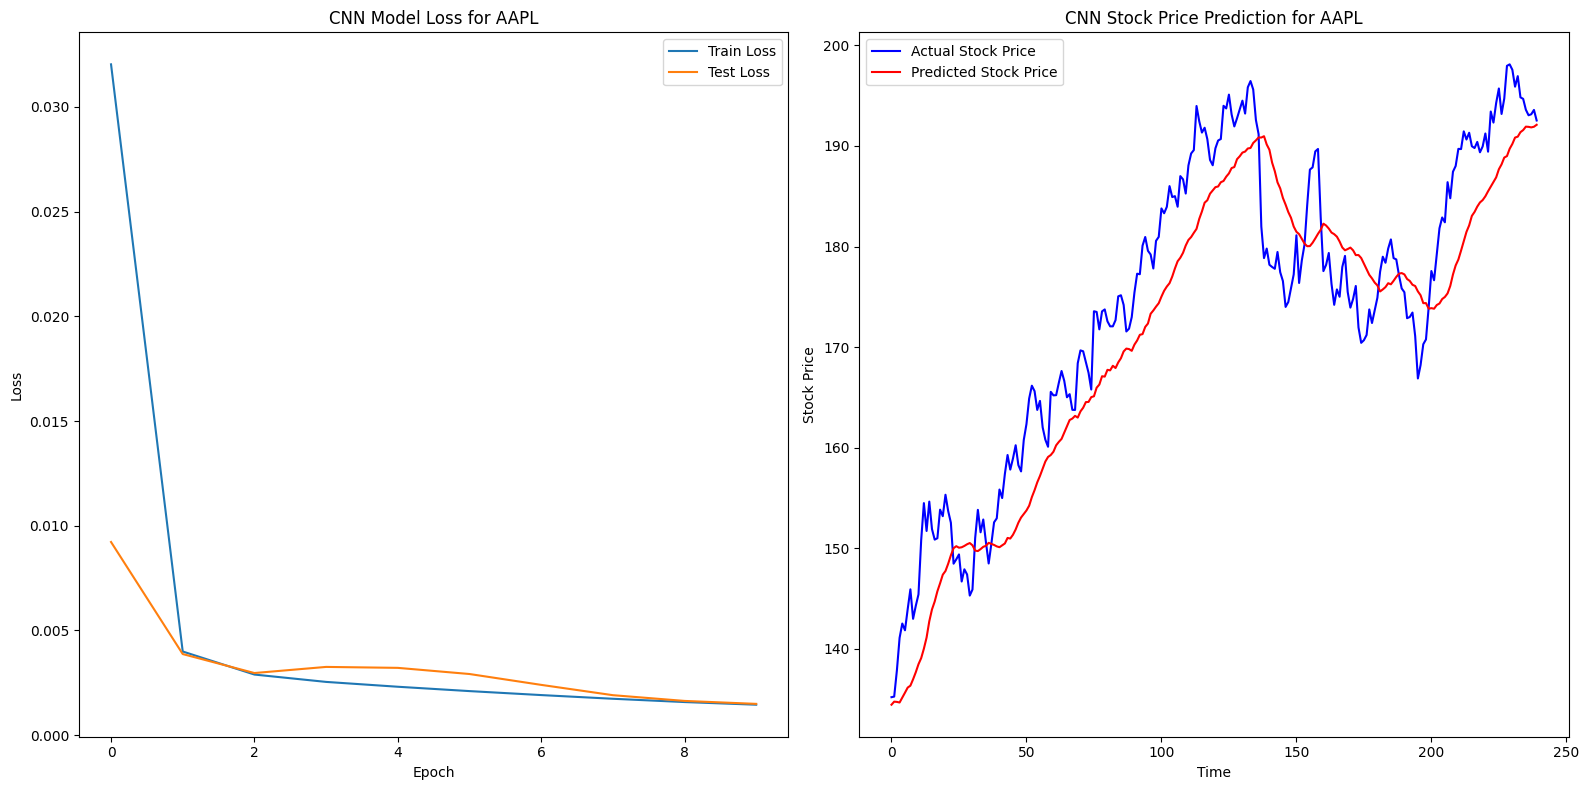


CNN Model Performance for AAPL:
Training Time: 4.41 seconds
Mean Squared Error: 39.56577916822669
Mean Absolute Error: 5.578491592407228
R^2 Score: 0.8310245410927624
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%***********************]  1 of 1 completed


Processing stock: GOOGL


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


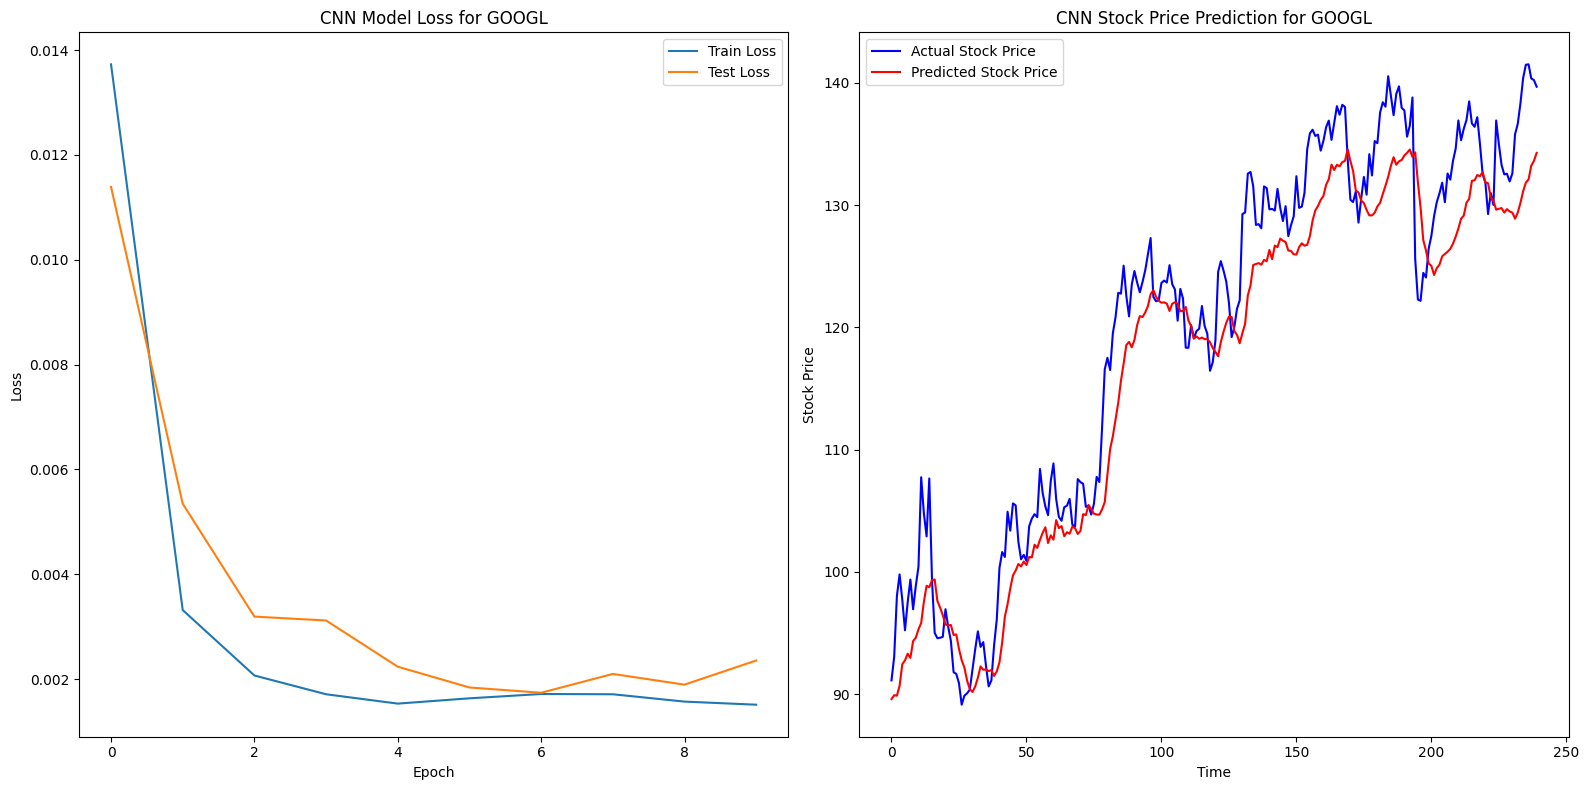


CNN Model Performance for GOOGL:
Training Time: 5.91 seconds
Mean Squared Error: 22.892843092478632
Mean Absolute Error: 3.962529913584391
R^2 Score: 0.9019033687364465
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Processing stock: NVDA


[*********************100%***********************]  1 of 1 completed


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


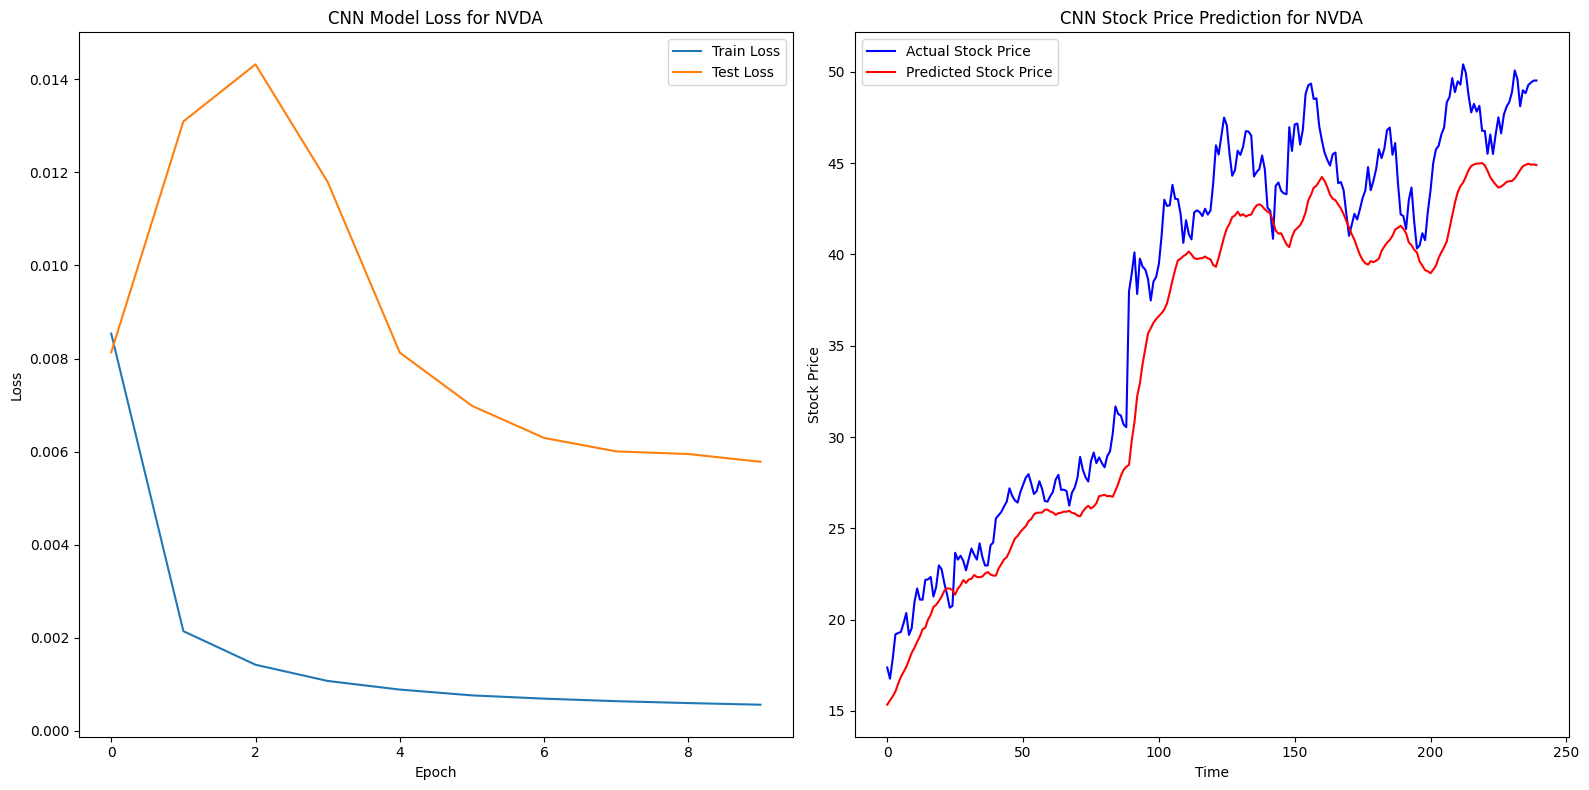


CNN Model Performance for NVDA:
Training Time: 4.18 seconds
Mean Squared Error: 12.883576325216415
Mean Absolute Error: 3.0385209520657854
R^2 Score: 0.8725136000431459
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%***********************]  1 of 1 completed


Processing stock: MSFT


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


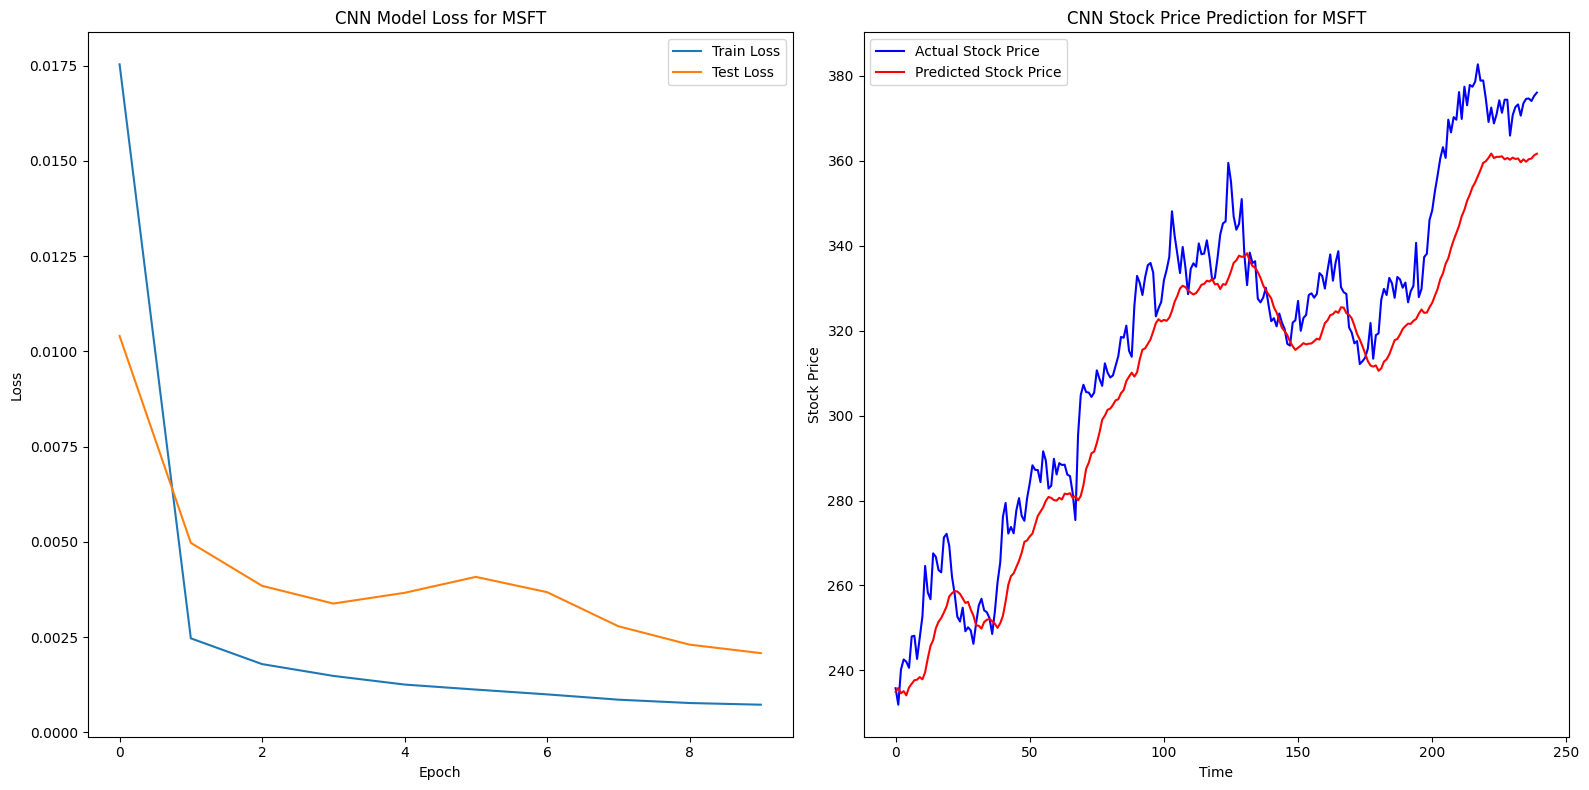


CNN Model Performance for MSFT:
Training Time: 3.86 seconds
Mean Squared Error: 169.10635449582387
Mean Absolute Error: 10.830139986673993
R^2 Score: 0.8836016112385207
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

Processing stock: TSLA


[*********************100%***********************]  1 of 1 completed


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


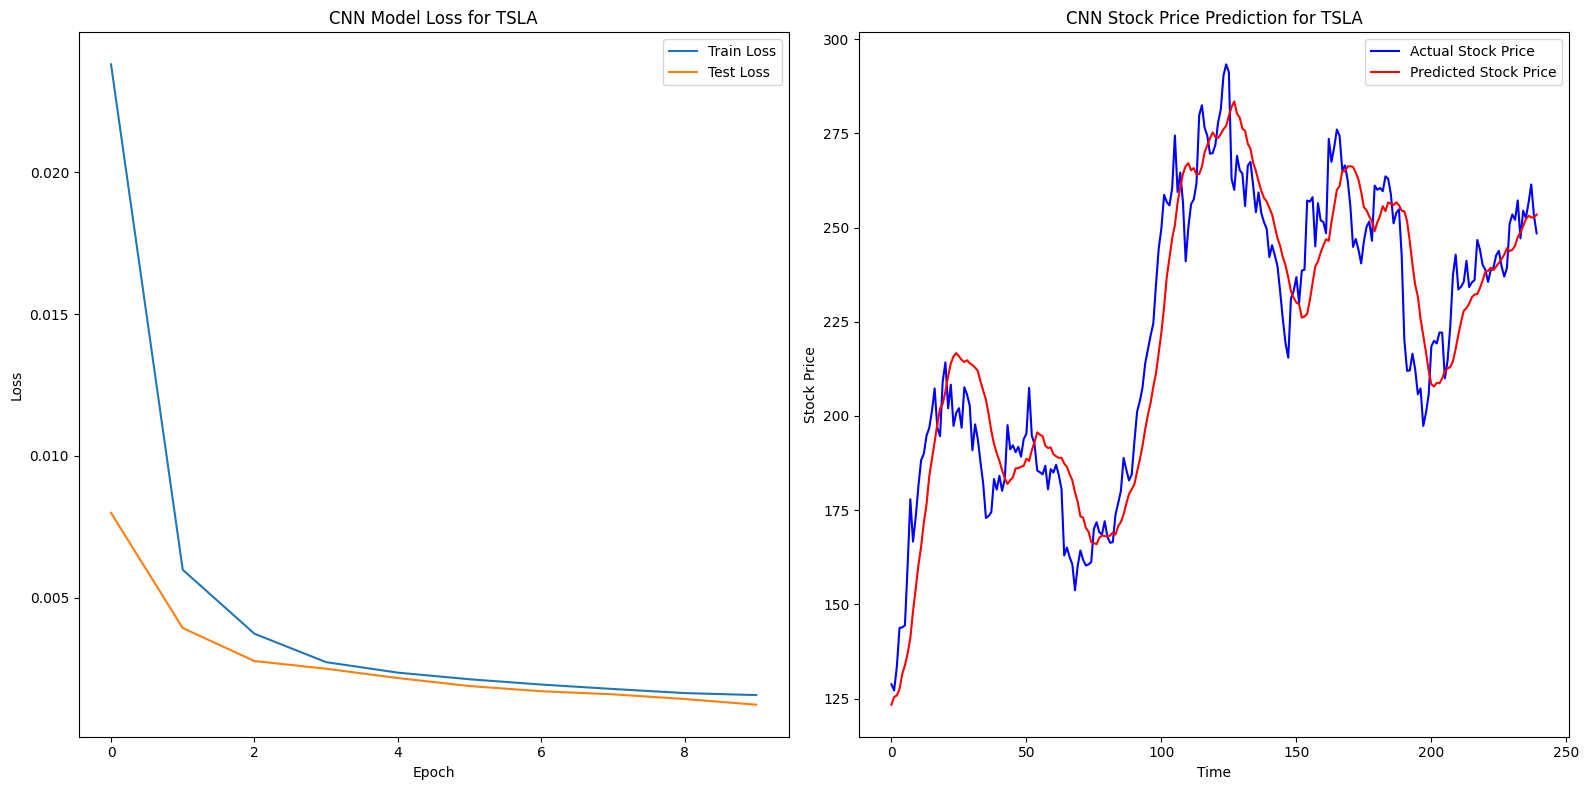


CNN Model Performance for TSLA:
Training Time: 4.68 seconds
Mean Squared Error: 194.2285475739421
Mean Absolute Error: 11.29966402053833
R^2 Score: 0.860799565202077
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%***********************]  1 of 1 completed


Processing stock: AMZN


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


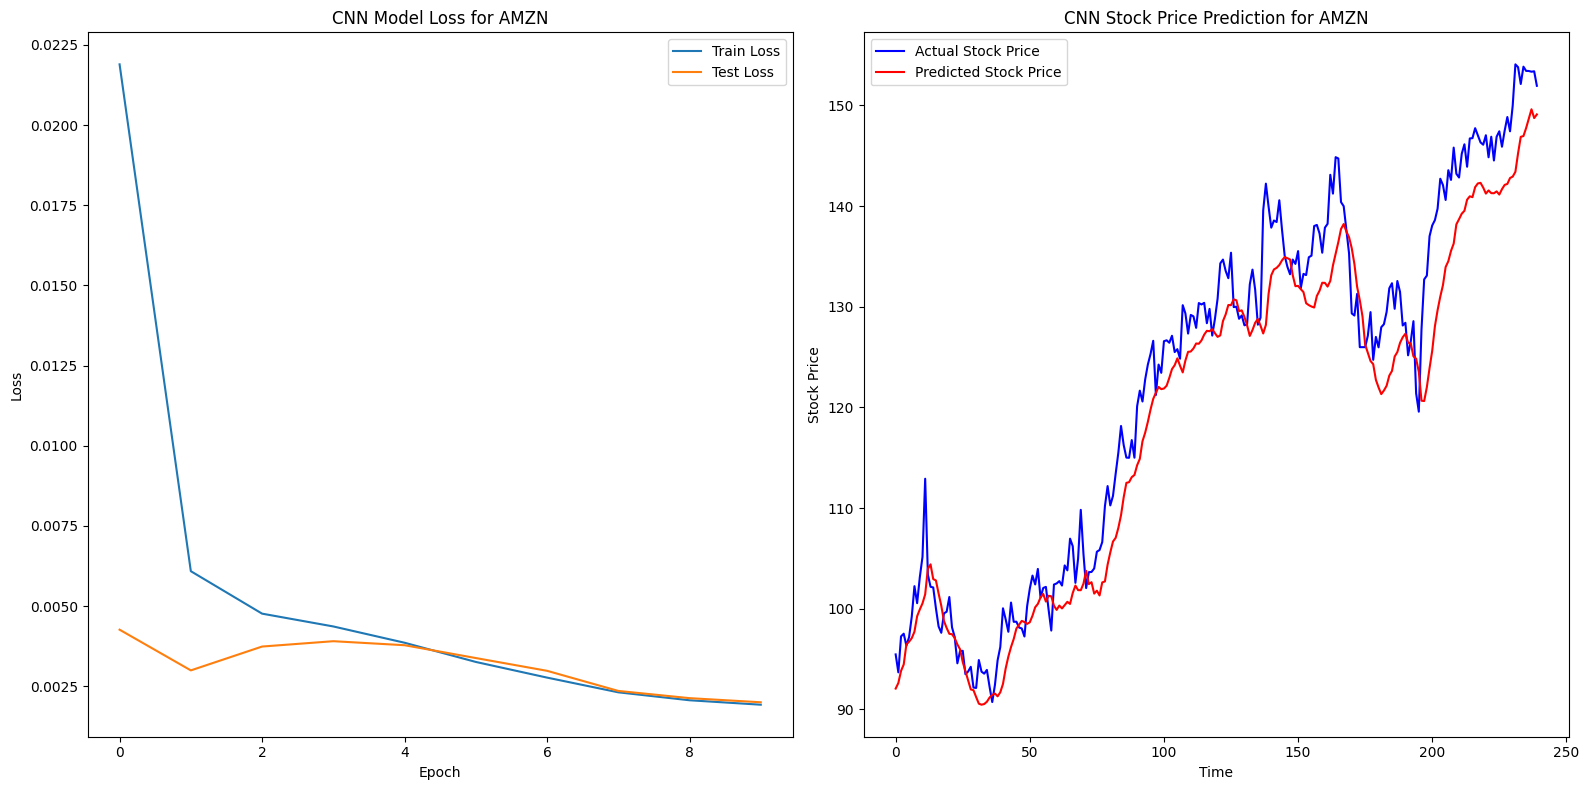


CNN Model Performance for AMZN:
Training Time: 4.20 seconds
Mean Squared Error: 24.862101831098457
Mean Absolute Error: 4.036838404337565
R^2 Score: 0.9240465757510276
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%***********************]  1 of 1 completed


Processing stock: META


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


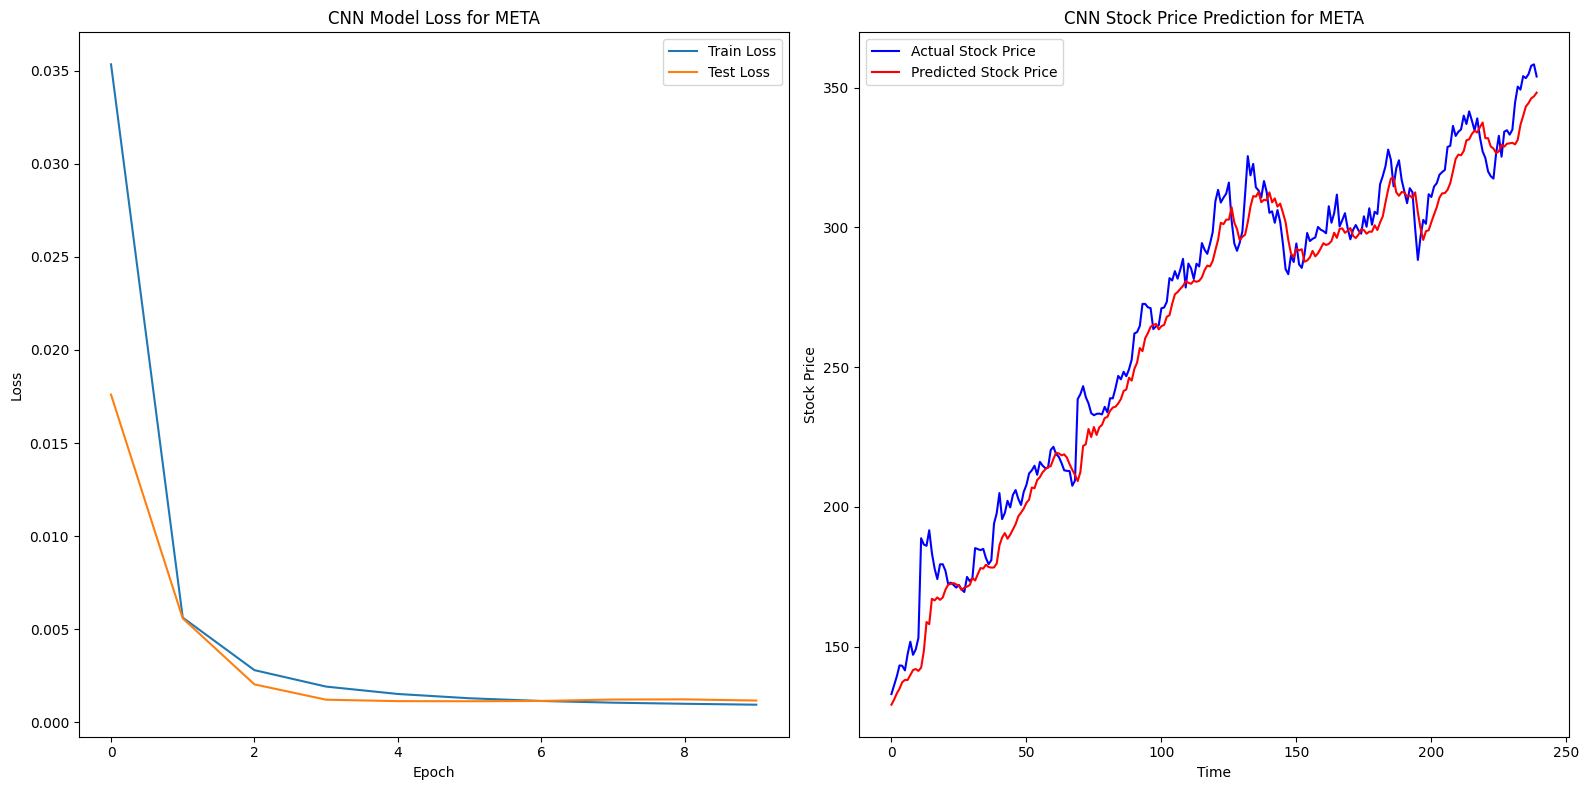


CNN Model Performance for META:
Training Time: 5.82 seconds
Mean Squared Error: 101.02906393388886
Mean Absolute Error: 7.786318397521971
R^2 Score: 0.9702742200684754
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Average Model Performance across all tickers:
Average Mean Squared Error (MSE): 80.65260948866786
Average Mean Absolute Error (MAE): 6.647500466732752
Average R² Score: 0.8920233545903509
Average Training Time: 4.72 seconds


In [ ]:
predictions_dict = {}
actual_values_dict = {}
tickers = ['AAPL', 'GOOGL', 'NVDA', 'MSFT', 'TSLA', 'AMZN', 'META']
start_date = '2019-01-01'
end_date = '2023-12-31'

# Lists to store performance metrics
mse_list = []
mae_list = []
r2_list = []
training_times = []

for ticker in tickers:
    print(f"\nProcessing stock: {ticker}")

    # Download and preprocess stock data
    stock_data = download_stock_data(ticker, start_date, end_date)
    X, y, scaler = preprocess_data(stock_data)

    # Split data into training and testing sets
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    cnn_model = build_cnn_model((X_train.shape[1], 1))

    # Train and evaluate the model for the current stock
    mse, mae, r2, training_time = train_and_evaluate_model(cnn_model, X_train, y_train, X_test, y_test, scaler, "CNN", ticker)

    # Append the results to lists
    mse_list.append(mse)
    mae_list.append(mae)
    r2_list.append(r2)
    training_times.append(training_time)

    predictions_dict[ticker] = cnn_model.predict(X_test)
    actual_values_dict[ticker] = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate average performance metrics
average_mse = np.mean(mse_list)
average_mae = np.mean(mae_list)
average_r2 = np.mean(r2_list)
average_training_time = np.mean(training_times)

# Print average performance metrics
print("\nAverage Model Performance across all tickers:")
print(f"Average Mean Squared Error (MSE): {average_mse}")
print(f"Average Mean Absolute Error (MAE): {average_mae}")
print(f"Average R² Score: {average_r2}")
print(f"Average Training Time: {average_training_time:.2f} seconds")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


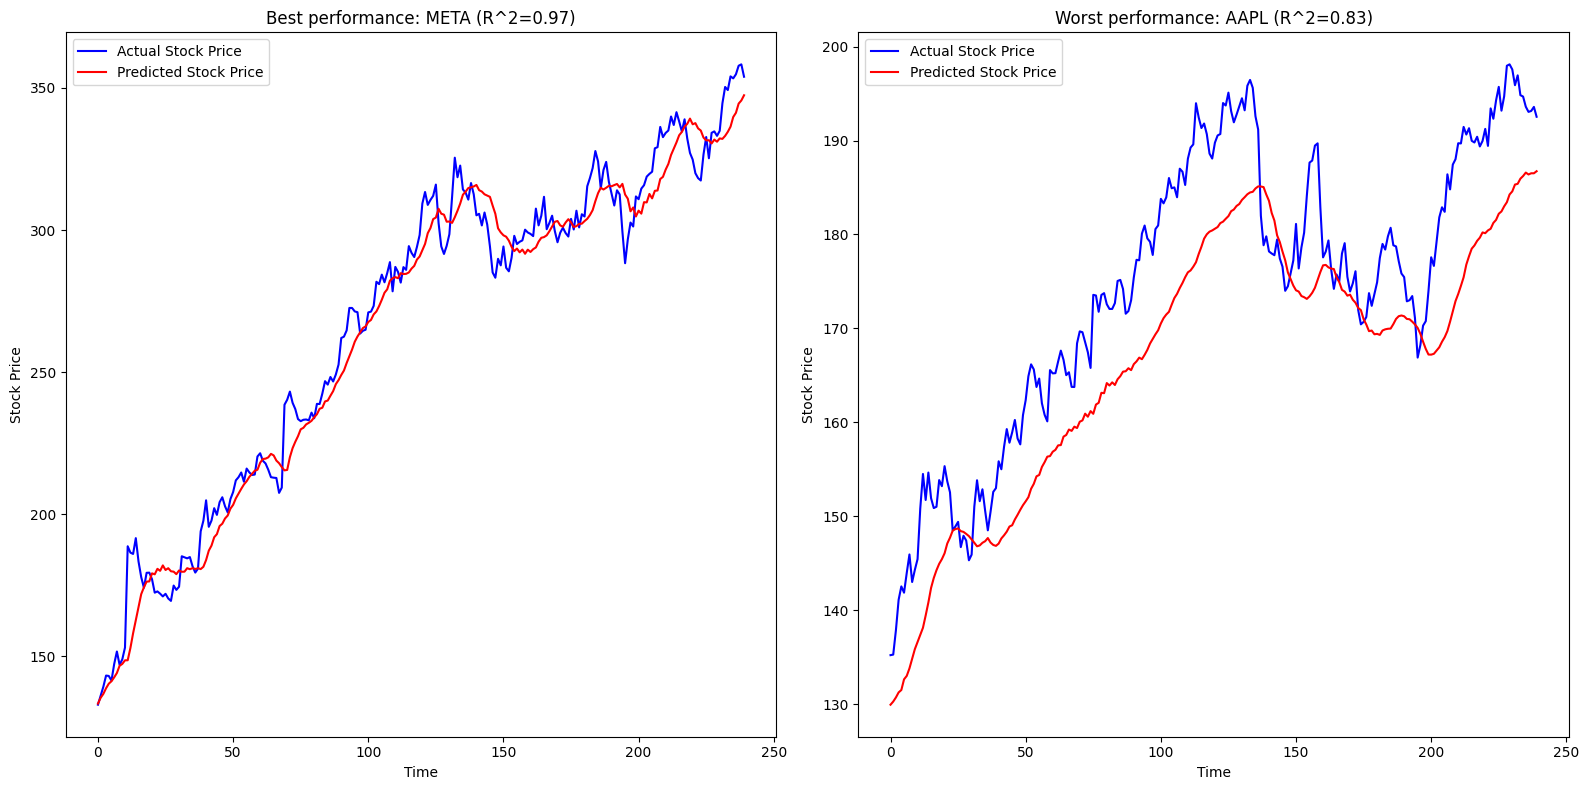

In [ ]:
# Identify the best and worst predictions based on R² score
best_index = np.argmax(r2_list)
worst_index = np.argmin(r2_list)

# Get corresponding tickers and predictions
best_ticker = tickers[best_index]
worst_ticker = tickers[worst_index]

# Re-download and preprocess the stock data for the best and worst tickers
best_stock_data = download_stock_data(best_ticker, start_date, end_date)
worst_stock_data = download_stock_data(worst_ticker, start_date, end_date)
X_best, y_best, best_scaler = preprocess_data(best_stock_data)
X_worst, y_worst, worst_scaler = preprocess_data(worst_stock_data)

# Split the data into training and testing sets for the best and worst tickers
split_best = int(0.8 * len(X_best))
split_worst = int(0.8 * len(X_worst))
X_test_best = X_best[split_best:]
y_test_best = y_best[split_best:]
X_test_worst = X_worst[split_worst:]
y_test_worst = y_worst[split_worst:]

# Rebuild and load the models
cnn_model_best = build_cnn_model((X_best.shape[1], 1))
cnn_model_worst = build_cnn_model((X_worst.shape[1], 1))

# Fit the models to get predictions (this can be skipped if already done earlier)
cnn_model_best.fit(X_best[:split_best], y_best[:split_best], epochs=10, batch_size=32, verbose=0)
cnn_model_worst.fit(X_worst[:split_worst], y_worst[:split_worst], epochs=10, batch_size=32, verbose=0)

# Make predictions for best and worst models
predictions_best = cnn_model_best.predict(X_test_best)
predictions_worst = cnn_model_worst.predict(X_test_worst)

# Plot best and worst model performance
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
plot_best_worst_performance(X_test_best, y_test_best, predictions_best, best_scaler, best_ticker, axs[0], 'Best', round(r2_list[best_index],2))
plot_best_worst_performance(X_test_worst, y_test_worst, predictions_worst, worst_scaler, worst_ticker, axs[1], 'Worst', round(r2_list[worst_index],2))
plt.tight_layout()
plt.show()


### **CNN -  CI Bootstrap Estimates**

In [ ]:
from sklearn.utils import resample

# Function to calculate bootstrap confidence intervals for MSE and R²
def bootstrap_ci(model_predictions, actual_values, n_iterations=1000, ci_level=95):
    mse_bootstrap = []
    r2_bootstrap = []

    # Bootstrap iterations
    for i in range(n_iterations):
        # Resample with replacement
        actual_resampled, pred_resampled = resample(actual_values, model_predictions)

        # Calculate MSE and R² for resampled data
        mse = mean_squared_error(actual_resampled, pred_resampled)
        r2 = r2_score(actual_resampled, pred_resampled)

        mse_bootstrap.append(mse)
        r2_bootstrap.append(r2)

    # Calculate confidence intervals
    lower_mse = np.percentile(mse_bootstrap, (100 - ci_level) / 2)
    upper_mse = np.percentile(mse_bootstrap, 100 - (100 - ci_level) / 2)

    lower_r2 = np.percentile(r2_bootstrap, (100 - ci_level) / 2)
    upper_r2 = np.percentile(r2_bootstrap, 100 - (100 - ci_level) / 2)

    return (lower_mse, upper_mse), (lower_r2, upper_r2)

# List to store confidence intervals for all stocks
mse_ci_all_stocks = []
r2_ci_all_stocks = []

for i, ticker in enumerate(tickers):
    print(f"\nProcessing stock: {ticker}")

    stock_data = download_stock_data(ticker, start_date, end_date)
    X, y, scaler = preprocess_data(stock_data)
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    cnn_model = build_cnn_model((X_train.shape[1], 1))
    cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    predictions = cnn_model.predict(X_test)

    # Inverse transform both actual and predicted values to original scale
    actual_values_scaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    model_predictions_scaled = scaler.inverse_transform(predictions).flatten()

    # Calculate bootstrap confidence intervals for the current stock
    mse_ci, r2_ci = bootstrap_ci(model_predictions_scaled, actual_values_scaled)

    # Store confidence intervals
    mse_ci_all_stocks.append(mse_ci)
    r2_ci_all_stocks.append(r2_ci)

    print(f'\nCNN Model MSE Confidence Interval for {ticker}: {mse_ci}')
    print(f'\nCNN Model R² Confidence Interval for {ticker}: {r2_ci}')

# Calculate the mean of all confidence intervals for MSE and R²
mean_mse_ci = np.mean(mse_ci_all_stocks, axis=0)
mean_r2_ci = np.mean(r2_ci_all_stocks, axis=0)

print("\nMean Confidence Interval Across All Stocks:")
print(f"Mean MSE Confidence Interval: {mean_mse_ci}")
print(f"Mean R² Confidence Interval: {mean_r2_ci}")


[*********************100%***********************]  1 of 1 completed


Processing stock: AAPL


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[*********************100%***********************]  1 of 1 completed


CNN Model MSE Confidence Interval for AAPL: (46.92490726746074, 59.074140131098474)

CNN Model R² Confidence Interval for AAPL: (0.7277424198498197, 0.8057680243917165)

Processing stock: GOOGL


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[*********************100%***********************]  1 of 1 completed


CNN Model MSE Confidence Interval for GOOGL: (18.81786250707807, 25.440581581443666)

CNN Model R² Confidence Interval for GOOGL: (0.8845166839761714, 0.9218777771068855)

Processing stock: NVDA


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[*********************100%***********************]  1 of 1 completed


CNN Model MSE Confidence Interval for NVDA: (14.00266920508359, 18.273133223925914)

CNN Model R² Confidence Interval for NVDA: (0.8104388330807035, 0.8677964450369113)

Processing stock: MSFT


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


[*********************100%***********************]  1 of 1 completed


CNN Model MSE Confidence Interval for MSFT: (187.12488506685997, 247.49489804148763)

CNN Model R² Confidence Interval for MSFT: (0.8178376412013865, 0.8758744228777225)

Processing stock: TSLA


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[*********************100%***********************]  1 of 1 completed


CNN Model MSE Confidence Interval for TSLA: (125.76108865936803, 176.44984628519217)

CNN Model R² Confidence Interval for TSLA: (0.8680018819510529, 0.9114723786921491)

Processing stock: AMZN


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[*********************100%***********************]  1 of 1 completed


CNN Model MSE Confidence Interval for AMZN: (9.364476054175139, 13.580961310713688)

CNN Model R² Confidence Interval for AMZN: (0.9564370746960202, 0.9725118299984427)

Processing stock: META


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

CNN Model MSE Confidence Interval for META: (57.718975726930545, 90.39470694891762)

CNN Model R² Confidence Interval for META: (0.9724593565868951, 0.9830938625133133)

Mean Confidence Interval Across All Stocks:
Mean MSE Confidence Interval: [65.67355207 90.10118107]
Mean R² Confidence Interval: [0.86249056 0.90548496]


Our model achieved a good result in predicting stock prices for all the tickers we looked at. The Mean Squared Error (MSE) came out to 80.65, which shows there's some variation in how accurate our predictions are. The Mean Absolute Error (MAE) of 6.64 tells us that, on average, our predictions are off by about 7 units - not too bad for stock prices. The R² score of 0.89 is also good, meaning out model explains about 89% of the variance in stock prices. Plus, it only takes about 4.72 seconds to train on average, so it's relatively quick and practical to use. We used bootstrap sampling to test our model's reliability, running it 1,000 times with different samples. This showed us that the average MSE falls between 65.67 and 90.10, and the R² score is typically between 0.86 and 0.91. These results suggest our model performs consistently well across different stocks.

### **CNN-LSTM model**

[*********************100%***********************]  1 of 1 completed


Processing stock: AAPL


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step


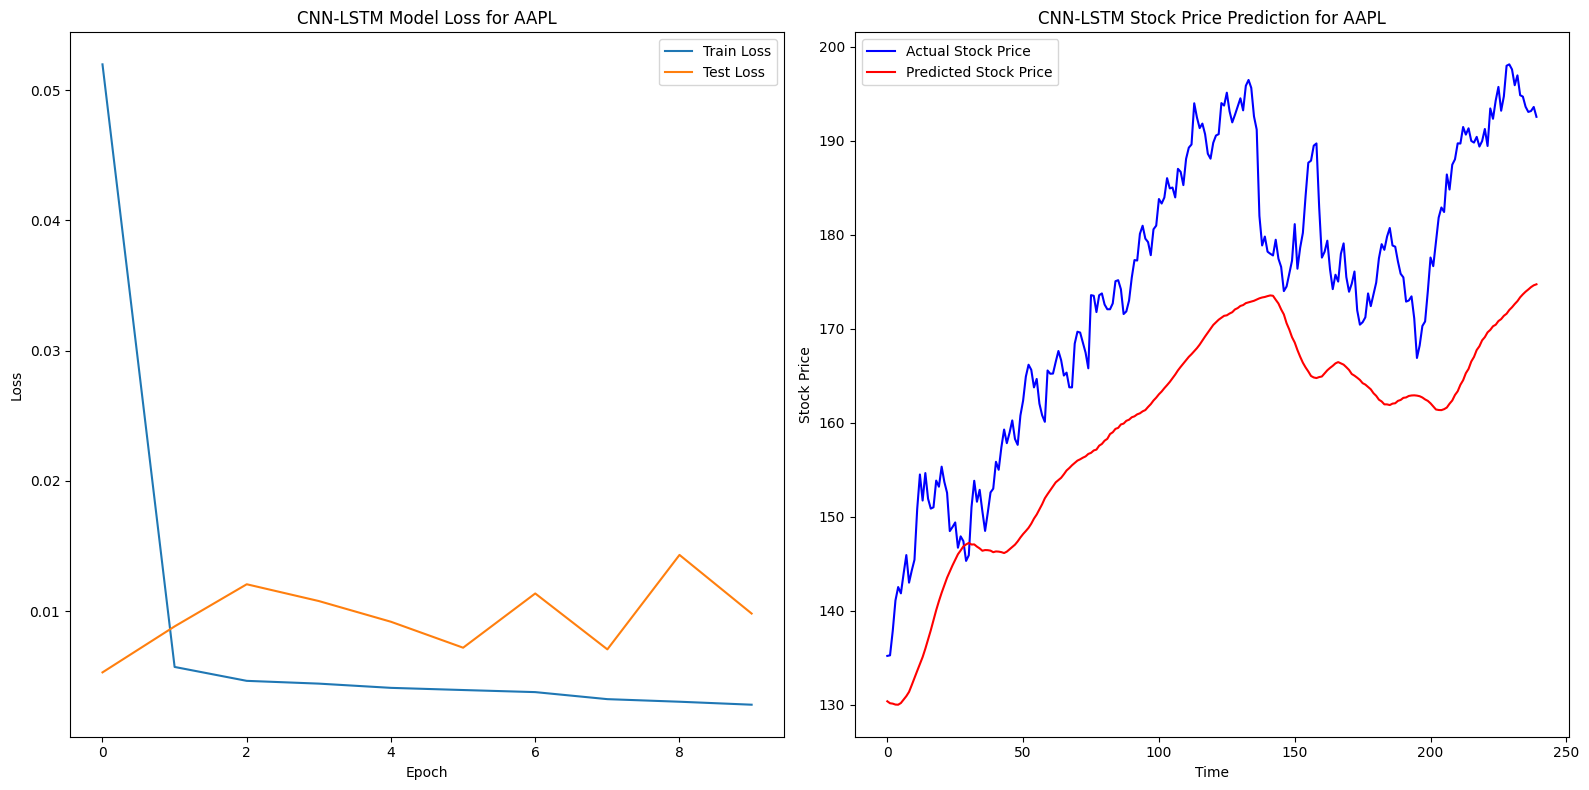


CNN-LSTM Model Performance for AAPL:
Training Time: 16.15 seconds
Mean Squared Error: 259.3385755669733
Mean Absolute Error: 14.740286127726238
R^2 Score: -0.10756961546127664
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


[*********************100%***********************]  1 of 1 completed


Processing stock: GOOGL


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


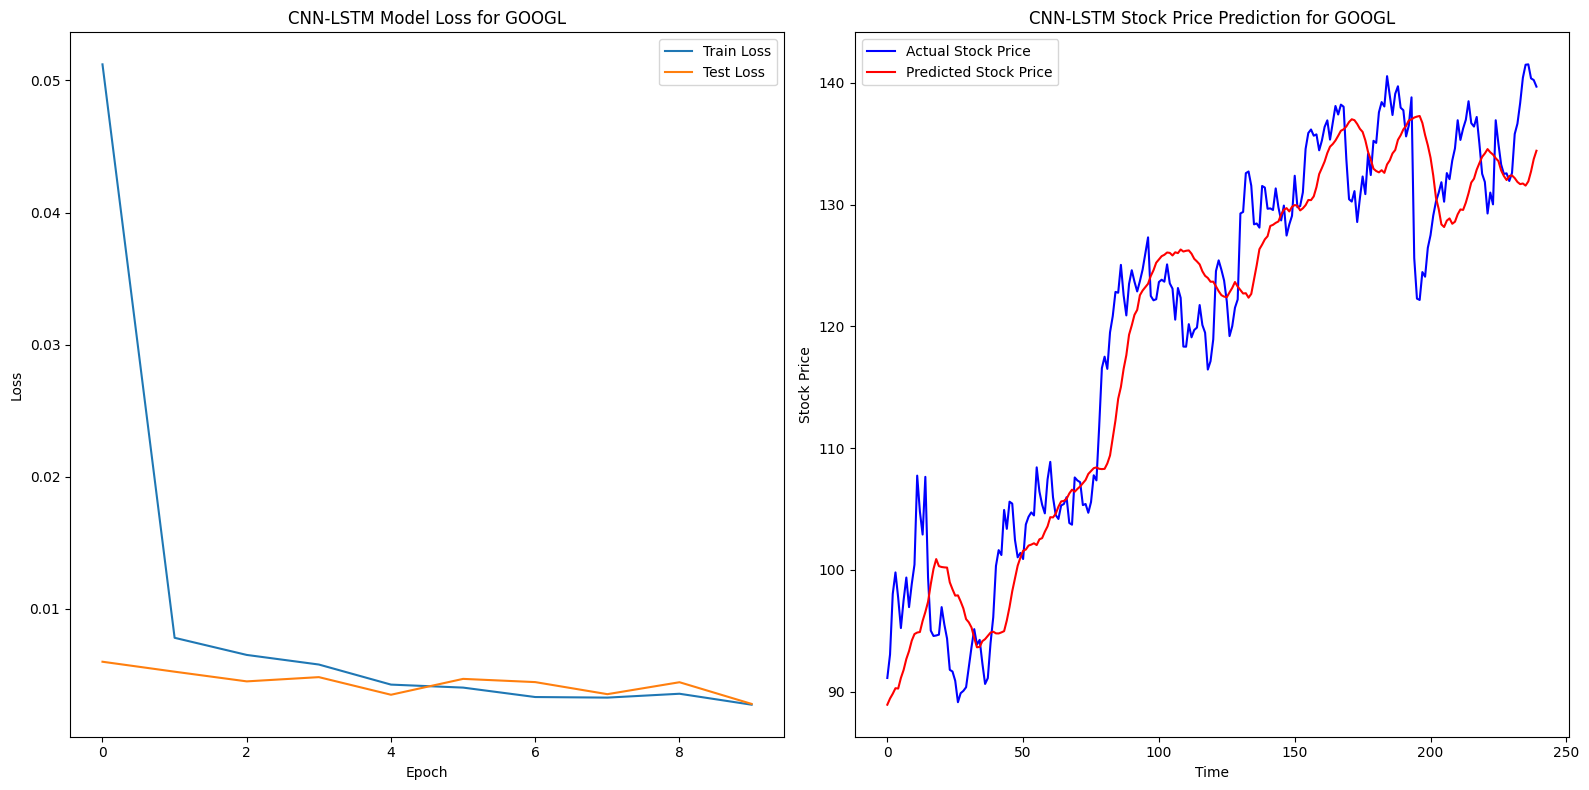


CNN-LSTM Model Performance for GOOGL:
Training Time: 15.58 seconds
Mean Squared Error: 27.217242322172392
Mean Absolute Error: 4.227328300476075
R^2 Score: 0.8833731671814009
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Processing stock: NVDA


[*********************100%***********************]  1 of 1 completed


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


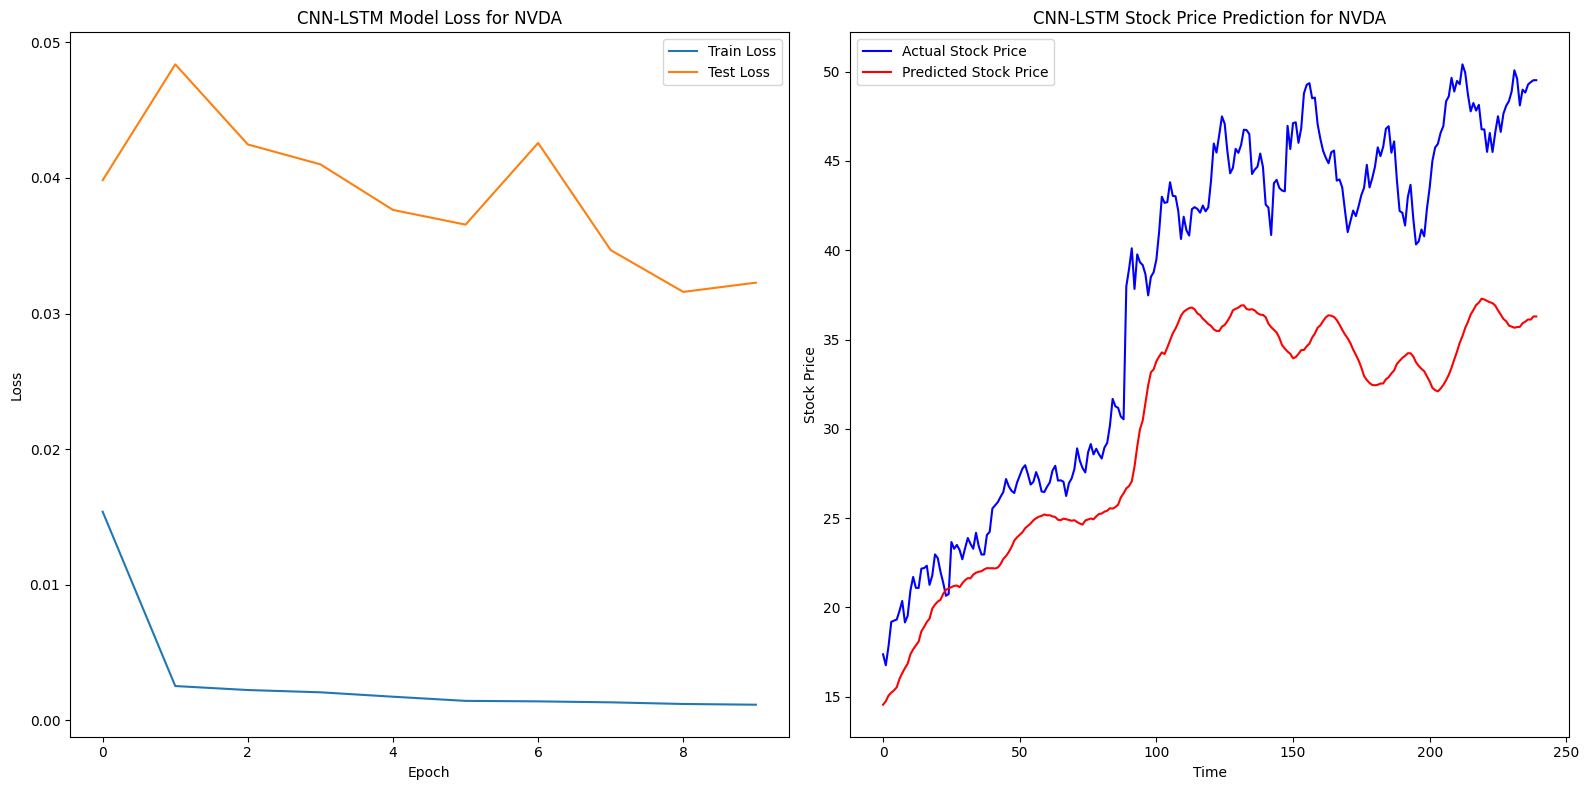


CNN-LSTM Model Performance for NVDA:
Training Time: 14.66 seconds
Mean Squared Error: 71.93635098077807
Mean Absolute Error: 7.358840143680572
R^2 Score: 0.28817075468227527
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


[*********************100%***********************]  1 of 1 completed


Processing stock: MSFT


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


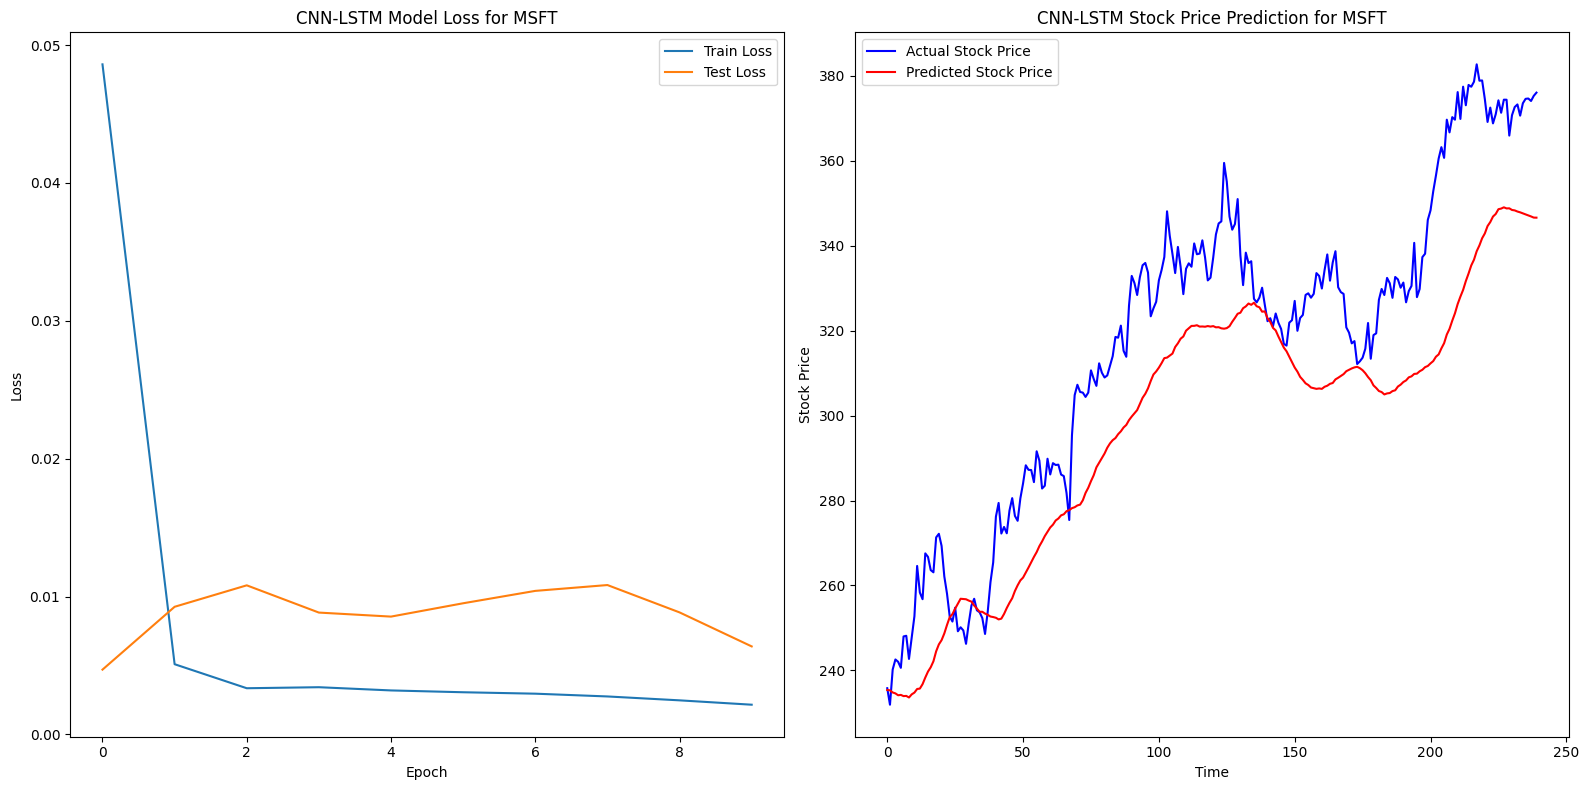


CNN-LSTM Model Performance for MSFT:
Training Time: 14.36 seconds
Mean Squared Error: 519.4862111543742
Mean Absolute Error: 19.71108849843343
R^2 Score: 0.6424300071842182
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


[*********************100%***********************]  1 of 1 completed


Processing stock: TSLA


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


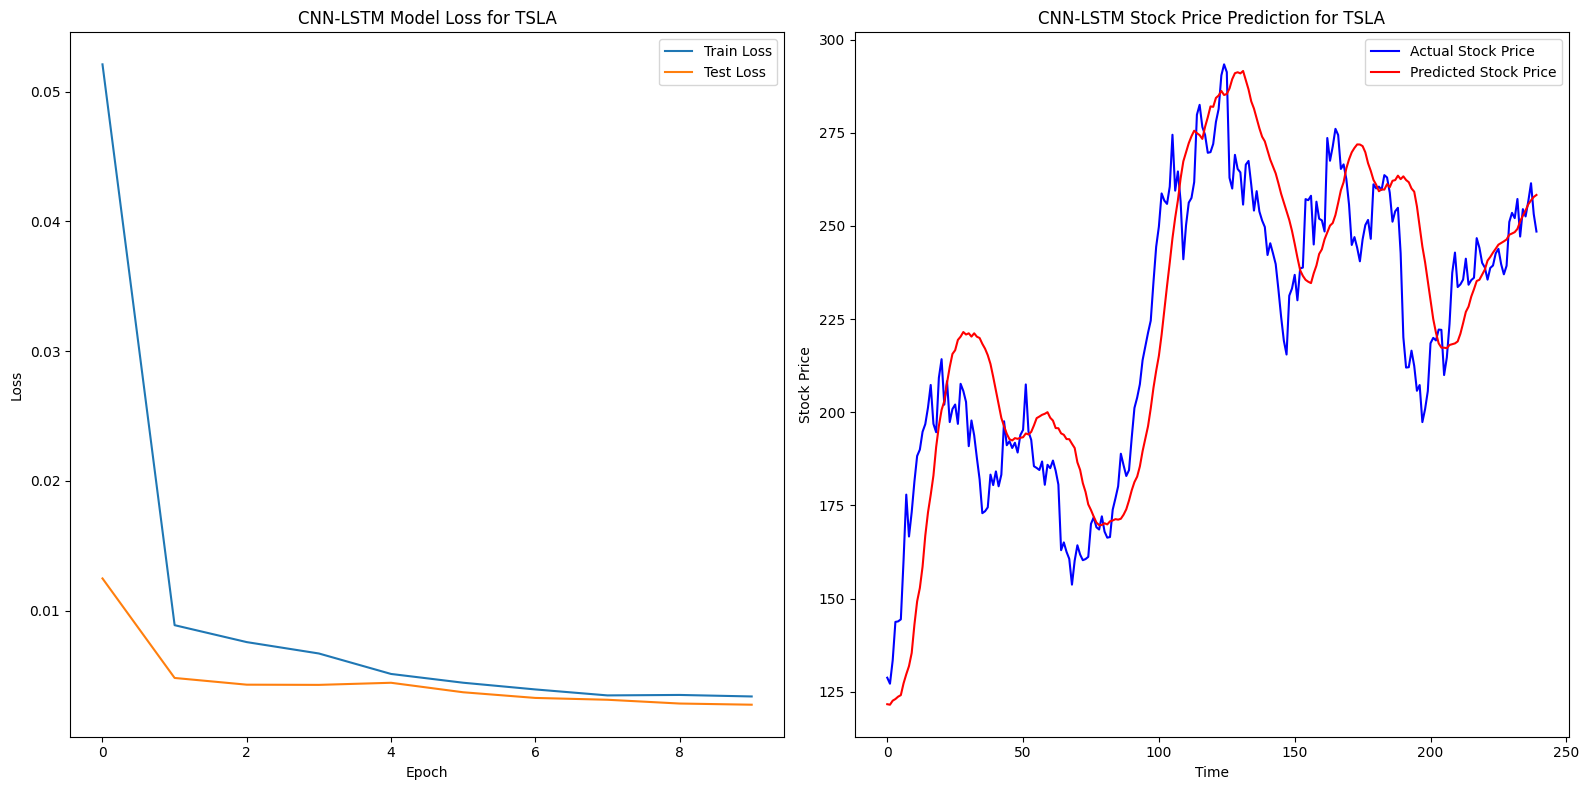


CNN-LSTM Model Performance for TSLA:
Training Time: 15.81 seconds
Mean Squared Error: 436.77348076009315
Mean Absolute Error: 16.64878120422363
R^2 Score: 0.6869715642245575
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[*********************100%***********************]  1 of 1 completed


Processing stock: AMZN


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step


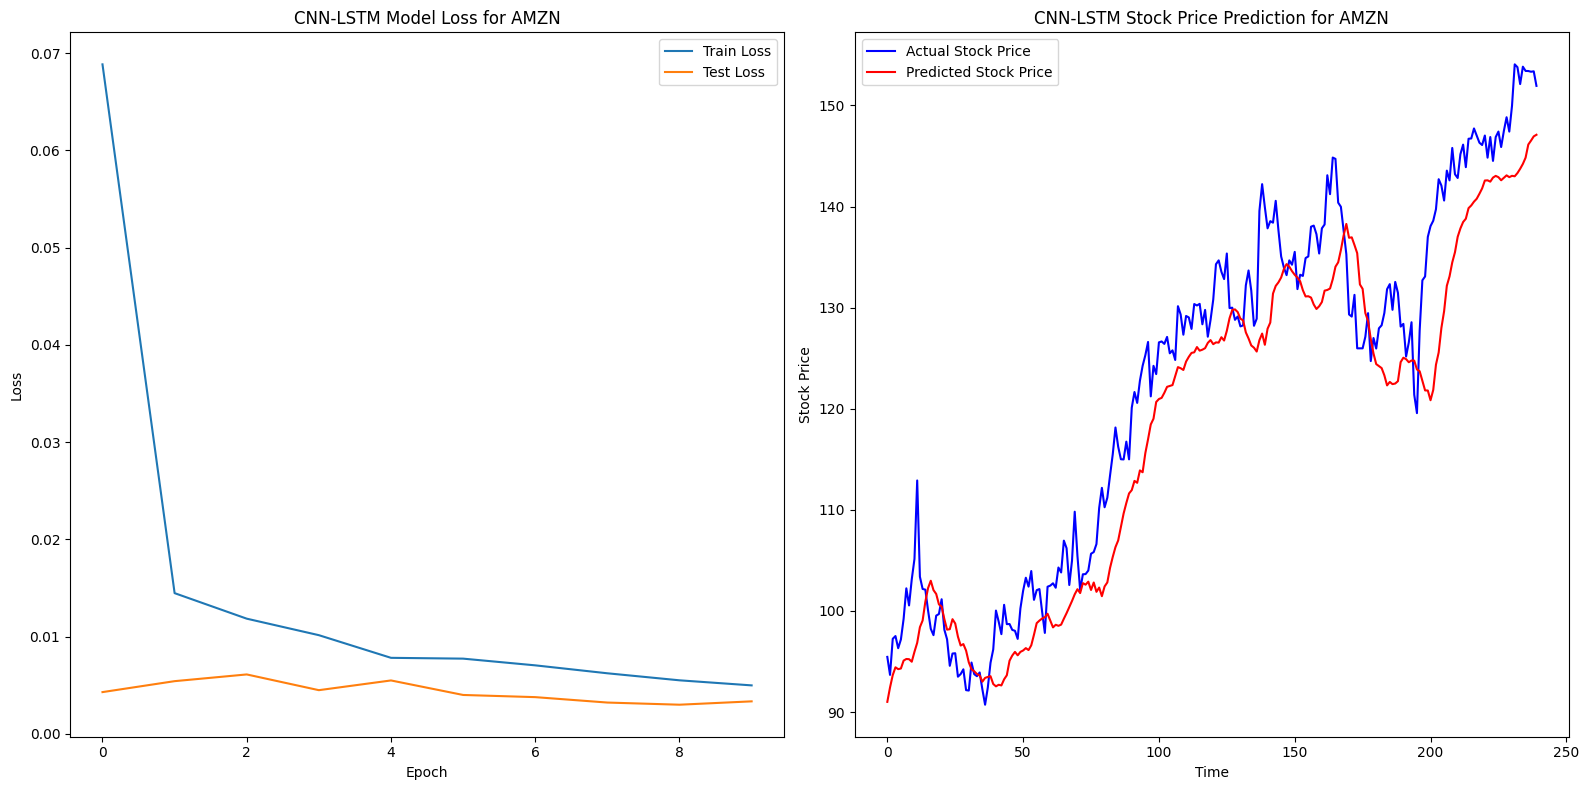


CNN-LSTM Model Performance for AMZN:
Training Time: 15.83 seconds
Mean Squared Error: 41.64214947802975
Mean Absolute Error: 5.344152641296387
R^2 Score: 0.8727837305377097
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[*********************100%***********************]  1 of 1 completed


Processing stock: META


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


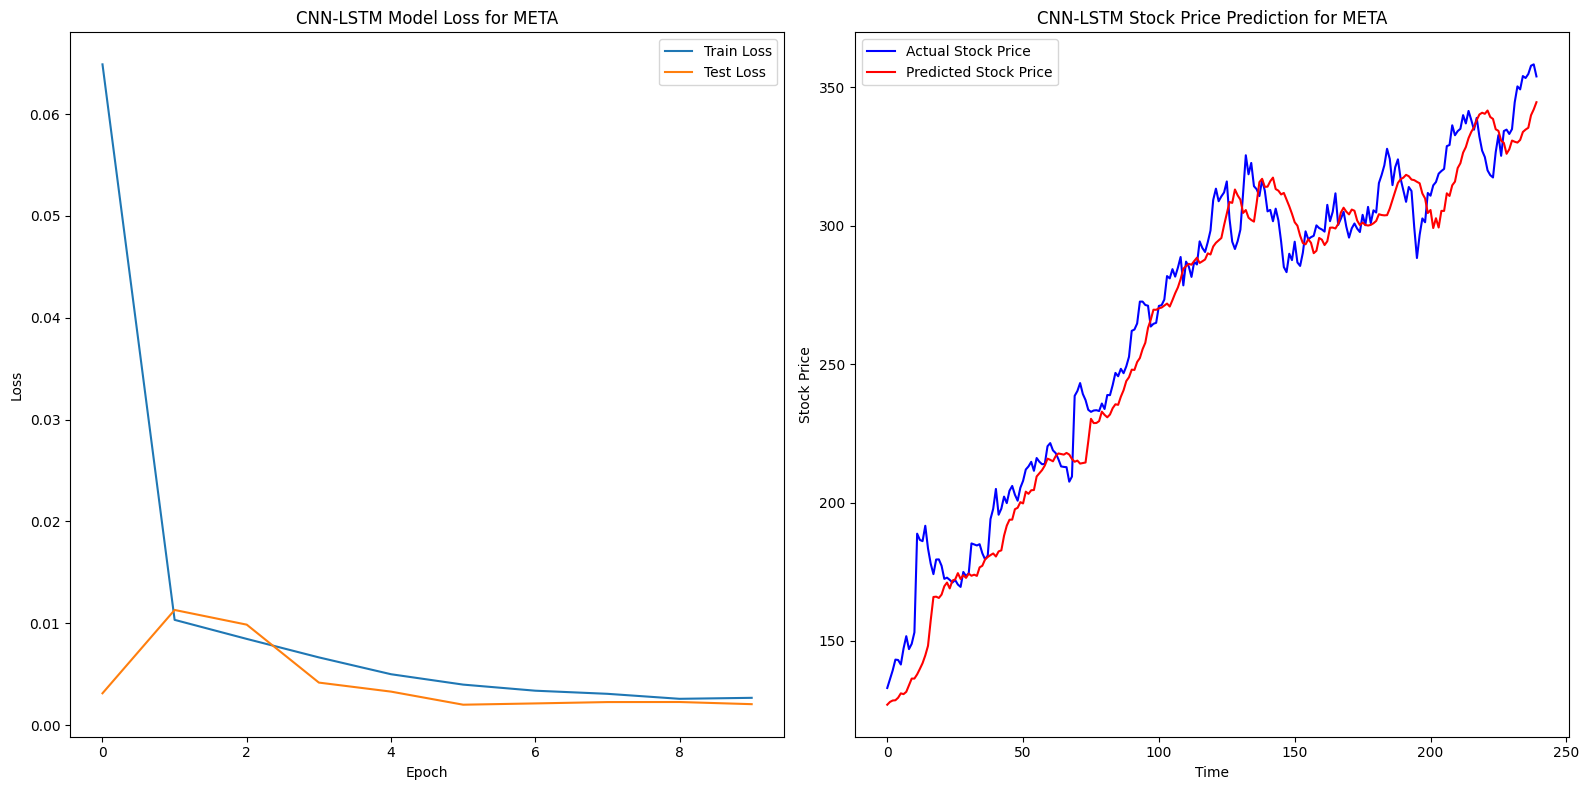


CNN-LSTM Model Performance for META:
Training Time: 19.94 seconds
Mean Squared Error: 176.12874560169124
Mean Absolute Error: 10.324877262115477
R^2 Score: 0.9481776418833556
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Average Model Performance across all tickers:
Average Mean Squared Error (MSE): 218.93182226630174
Average Mean Absolute Error (MAE): 11.193622025421687
Average R² Score: 0.6020481786046058
Average Training Time: 16.05 seconds


In [ ]:
# Lists to store performance metrics
mse_list = []
mae_list = []
r2_list = []
training_times = []

for ticker in tickers:
    print(f"\nProcessing stock: {ticker}")

    # Download and preprocess stock data
    stock_data = download_stock_data(ticker, start_date, end_date)
    X, y, scaler = preprocess_data(stock_data)
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Reshape data for CNN-LSTM model
    # Reshaping X to have 4D shape: (samples, timesteps, features, 1)
    X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1], 1))
    X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1], 1))

    # Build and train the CNN-LSTM model
    cnn_lstm_model = build_cnn_lstm_model((1, X_train.shape[1], 1))  # Input shape (timesteps, features, channels)

    # Train and evaluate the model for the current stock
    mse, mae, r2, training_time = train_and_evaluate_model(cnn_lstm_model, X_train_lstm, y_train, X_test_lstm, y_test, scaler, "CNN-LSTM", ticker)

    # Append the results to lists
    mse_list.append(mse)
    mae_list.append(mae)
    r2_list.append(r2)
    training_times.append(training_time)

    predictions_dict[ticker] = cnn_lstm_model.predict(X_test_lstm)
    actual_values_dict[ticker] = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate average performance metrics
average_mse = np.mean(mse_list)
average_mae = np.mean(mae_list)
average_r2 = np.mean(r2_list)
average_training_time = np.mean(training_times)

# Print average performance metrics
print("\nAverage Model Performance across all tickers:")
print(f"Average Mean Squared Error (MSE): {average_mse}")
print(f"Average Mean Absolute Error (MAE): {average_mae}")
print(f"Average R² Score: {average_r2}")
print(f"Average Training Time: {average_training_time:.2f} seconds")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


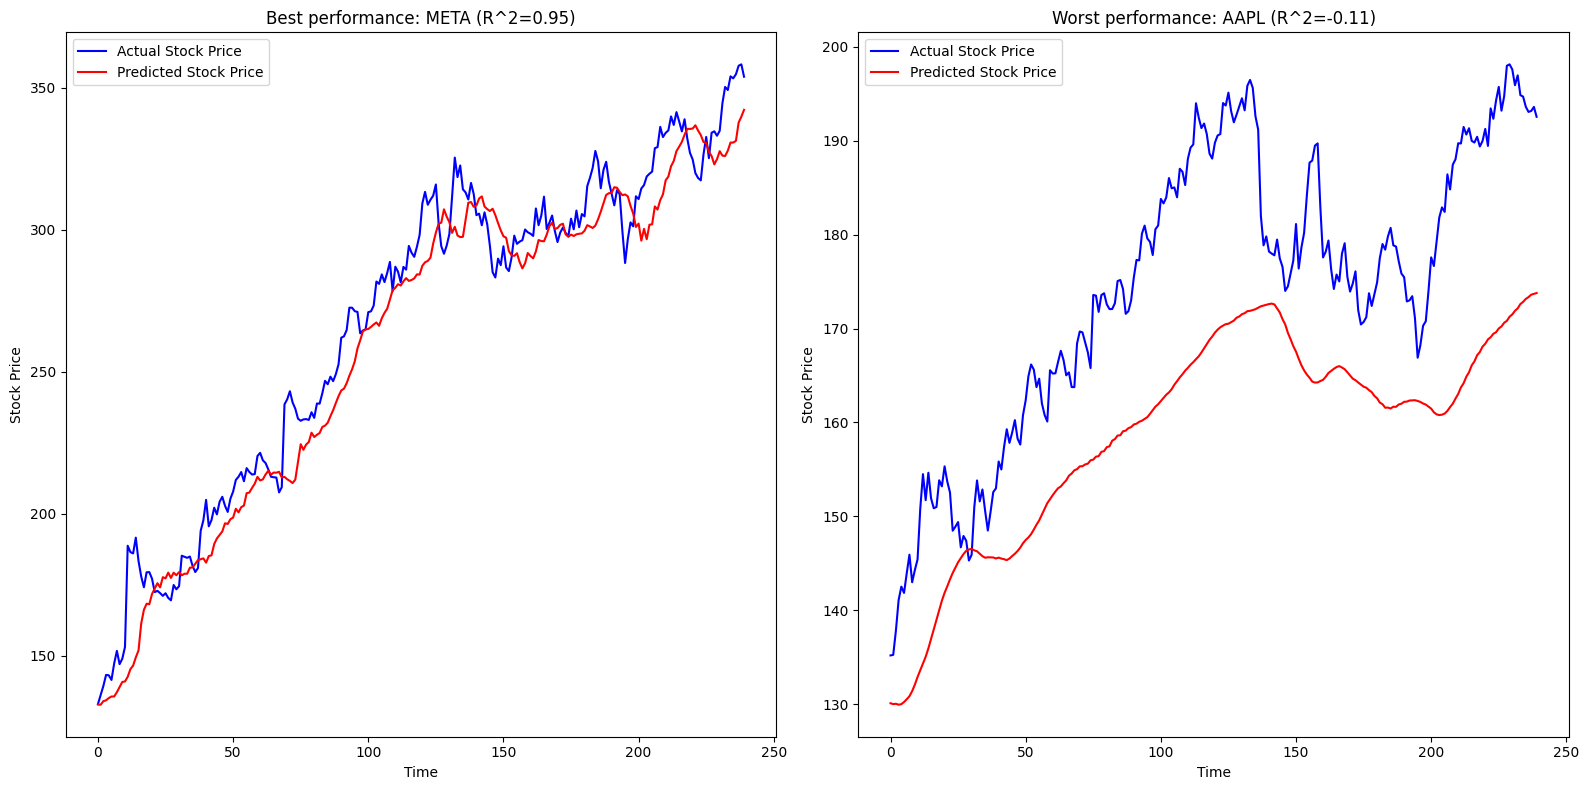

In [ ]:
# Identify the best and worst predictions based on R² score
best_index = np.argmax(r2_list)
worst_index = np.argmin(r2_list)

# Get corresponding tickers and predictions
best_ticker = tickers[best_index]
worst_ticker = tickers[worst_index]

# Re-download and preprocess the stock data for the best and worst tickers
best_stock_data = download_stock_data(best_ticker, start_date, end_date)
worst_stock_data = download_stock_data(worst_ticker, start_date, end_date)
X_best, y_best, best_scaler = preprocess_data(best_stock_data)
X_worst, y_worst, worst_scaler = preprocess_data(worst_stock_data)

# Split the data into training and testing sets for the best and worst tickers
split_best = int(0.8 * len(X_best))
split_worst = int(0.8 * len(X_worst))
X_test_best = X_best[split_best:]
y_test_best = y_best[split_best:]
X_test_worst = X_worst[split_worst:]
y_test_worst = y_worst[split_worst:]

# Reshape data for CNN-LSTM model
X_train_best = np.reshape(X_best[:split_best], (split_best, 1, X_best.shape[1], 1))
X_test_best = np.reshape(X_test_best, (X_test_best.shape[0], 1, X_test_best.shape[1], 1))
X_train_worst = np.reshape(X_worst[:split_worst], (split_worst, 1, X_worst.shape[1], 1))
X_test_worst = np.reshape(X_test_worst, (X_test_worst.shape[0], 1, X_test_worst.shape[1], 1))

# Rebuild and load the models
cnn_lstm_model_best = build_cnn_lstm_model((1, X_best.shape[1], 1))
cnn_lstm_model_worst = build_cnn_lstm_model((1, X_worst.shape[1], 1))

# Fit the models to get predictions
cnn_lstm_model_best.fit(X_train_best, y_best[:split_best], epochs=10, batch_size=32, verbose=0)
cnn_lstm_model_worst.fit(X_train_worst, y_worst[:split_worst], epochs=10, batch_size=32, verbose=0)

# Make predictions for best and worst models
predictions_best = cnn_lstm_model_best.predict(X_test_best)
predictions_worst = cnn_lstm_model_worst.predict(X_test_worst)

# Plot best and worst model performance
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
plot_best_worst_performance(X_test_best, y_test_best, predictions_best, best_scaler, best_ticker, axs[0], 'Best', round(r2_list[best_index], 2))
plot_best_worst_performance(X_test_worst, y_test_worst, predictions_worst, worst_scaler, worst_ticker, axs[1], 'Worst', round(r2_list[worst_index], 2))
plt.tight_layout()
plt.show()

### **CNN-LSTM - CI Bootstrap Estimates**


1. **Input**:  
   Input shape $(1, 60, 1)$, representing a window of 60 stock prices.

2. **TimeDistributed Conv1D Layers**:  
   Applies filters to detect short-term patterns:
   $$
   y(t) = \sum_{i=1}^{k} w_i \cdot x(t+i) + b
 $$
   where $ w_i $ are filter weights, and $ x(t+i) $ are stock prices.

3. **TimeDistributed MaxPooling**:  
   Reduces the dimensionality by selecting important features from convolution outputs.

4. **Flattening**:  
   Converts the pooled data into a 1D vector for LSTM input.

5. **LSTM Layers**:  
   Learns long-term dependencies using gates:
   $$
   f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f), \quad C_t = f_t * C_{t-1} + i_t * \tilde{C_t}
 $$
   where $ f_t $ is the forget gate, $ C_t $ is the cell state.

6. **Dropout**:  
   Prevents overfitting by randomly zeroing out some LSTM outputs.

7. **Final Dense Layer**:  
   Outputs a single predicted stock price.



The bootstrap results for the model's MSE fall within the range of 182.11 to 241.50, while the R² score lies between 0.53 and 0.67, indicating that the model captures approximately 53% to 67% of the variance in stock prices across all tickers.
The model's performance was probably limited because stock price movements are influenced by highly complex, non-linear factors and external events that an LSTM-based model, which primarily captures temporal dependencies, may not fully capture or generalize across different stocks.


In [ ]:
mse_ci_all_stocks = []
r2_ci_all_stocks = []

for i, ticker in enumerate(tickers):
    print(f"\nProcessing stock: {ticker}")

    stock_data = download_stock_data(ticker, start_date, end_date)
    X, y, scaler = preprocess_data(stock_data)
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Reshape data for CNN-LSTM model
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1], 1))

    cnn_lstm_model = build_cnn_lstm_model((1, X_train.shape[2], 1))
    cnn_lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    predictions = cnn_lstm_model.predict(X_test)

    # Inverse transform both actual and predicted values to original scale
    actual_values_scaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    model_predictions_scaled = scaler.inverse_transform(predictions).flatten()

    # Calculate bootstrap confidence intervals for the current stock
    mse_ci, r2_ci = bootstrap_ci(model_predictions_scaled, actual_values_scaled)

    # Store confidence intervals
    mse_ci_all_stocks.append(mse_ci)
    r2_ci_all_stocks.append(r2_ci)

    print(f'\nCNN-LSTM Model MSE Confidence Interval for {ticker}: {mse_ci}')
    print(f'\nCNN-LSTM Model R² Confidence Interval for {ticker}: {r2_ci}')

# Calculate the mean of all confidence intervals for MSE and R²
mean_mse_ci = np.mean(mse_ci_all_stocks, axis=0)
mean_r2_ci = np.mean(r2_ci_all_stocks, axis=0)

print("\nMean Confidence Interval Across All Stocks:")
print(f"Mean MSE Confidence Interval: {mean_mse_ci}")
print(f"Mean R² Confidence Interval: {mean_r2_ci}")

[*********************100%***********************]  1 of 1 completed


Processing stock: AAPL


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


[*********************100%***********************]  1 of 1 completed


CNN-LSTM Model MSE Confidence Interval for AAPL: (198.44138770379558, 240.47643028088322)

CNN-LSTM Model R² Confidence Interval for AAPL: (-0.13671157180038537, 0.1994892592052143)

Processing stock: GOOGL


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


[*********************100%***********************]  1 of 1 completed


CNN-LSTM Model MSE Confidence Interval for GOOGL: (45.66288888965995, 59.22394131595702)

CNN-LSTM Model R² Confidence Interval for GOOGL: (0.727560645314266, 0.8132317013326172)

Processing stock: NVDA


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


[*********************100%***********************]  1 of 1 completed


CNN-LSTM Model MSE Confidence Interval for NVDA: (66.22194288717, 82.79628375988693)

CNN-LSTM Model R² Confidence Interval for NVDA: (0.11836300779317059, 0.36774515013016457)

Processing stock: MSFT


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


[*********************100%***********************]  1 of 1 completed


CNN-LSTM Model MSE Confidence Interval for MSFT: (412.52031537114533, 539.7135378455025)

CNN-LSTM Model R² Confidence Interval for MSFT: (0.606483576147235, 0.7216252053523444)

Processing stock: TSLA


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


[*********************100%***********************]  1 of 1 completed


CNN-LSTM Model MSE Confidence Interval for TSLA: (386.56840055152986, 527.3217728783119)

CNN-LSTM Model R² Confidence Interval for TSLA: (0.598243342083143, 0.734212602398344)

Processing stock: AMZN


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


[*********************100%***********************]  1 of 1 completed


CNN-LSTM Model MSE Confidence Interval for AMZN: (32.510819542736044, 44.177232818998355)

CNN-LSTM Model R² Confidence Interval for AMZN: (0.8567758680019978, 0.904331396018093)

Processing stock: META


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step

CNN-LSTM Model MSE Confidence Interval for META: (132.8660091591216, 196.787002905432)

CNN-LSTM Model R² Confidence Interval for META: (0.9394421374014658, 0.9622951554715597)

Mean Confidence Interval Across All Stocks:
Mean MSE Confidence Interval: [182.11310916 241.4994574 ]
Mean R² Confidence Interval: [0.53002243 0.67184721]


### **Arima + XGboost Residuals Prediction**

ARIMA (AutoRegressive Integrated Moving Average) is used to capture linear patterns and trends in the stock price data.
We fit an ARIMA model to the 'Close' prices of the stock data. This model helps in understanding the underlying linear dynamics and residuals (the differences between the actual prices and the values predicted by ARIMA).

For the original stock data, We scale it and prepare it for training.
After applying ARIMA, We use the residuals (errors from ARIMA predictions) to train a separate model. The residuals are expected to capture patterns that ARIMA couldn't model.

XGBoost (Extreme Gradient Boosting) is a powerful machine learning model that can capture complex, non-linear relationships in the data.
We use XGBoost to predict the residuals from the ARIMA model. This helps refine the forecast by correcting the ARIMA model’s predictions with XGBoost.


After obtaining the residuals from the ARIMA model, We preprocess these residuals and train an XGBoost model on them.
We then use the trained XGBoost model to predict residuals, which We can combine with the ARIMA predictions to get an improved forecast.


The article suggests that traditional ARIMA models struggle with capturing non-linearities in stock price predictions. To overcome this, the proposed model integrates ARIMA with deep learning techniques (CNN) and XGBoost. The CNN model extracts deep features from the stock data, while XGBoost fine-tunes the predictions. Our approach aligns with this by using ARIMA for initial linear modeling and XGBoost for refining the predictions based on residuals.

[*********************100%***********************]  1 of 1 completed


Processing stock: AAPL


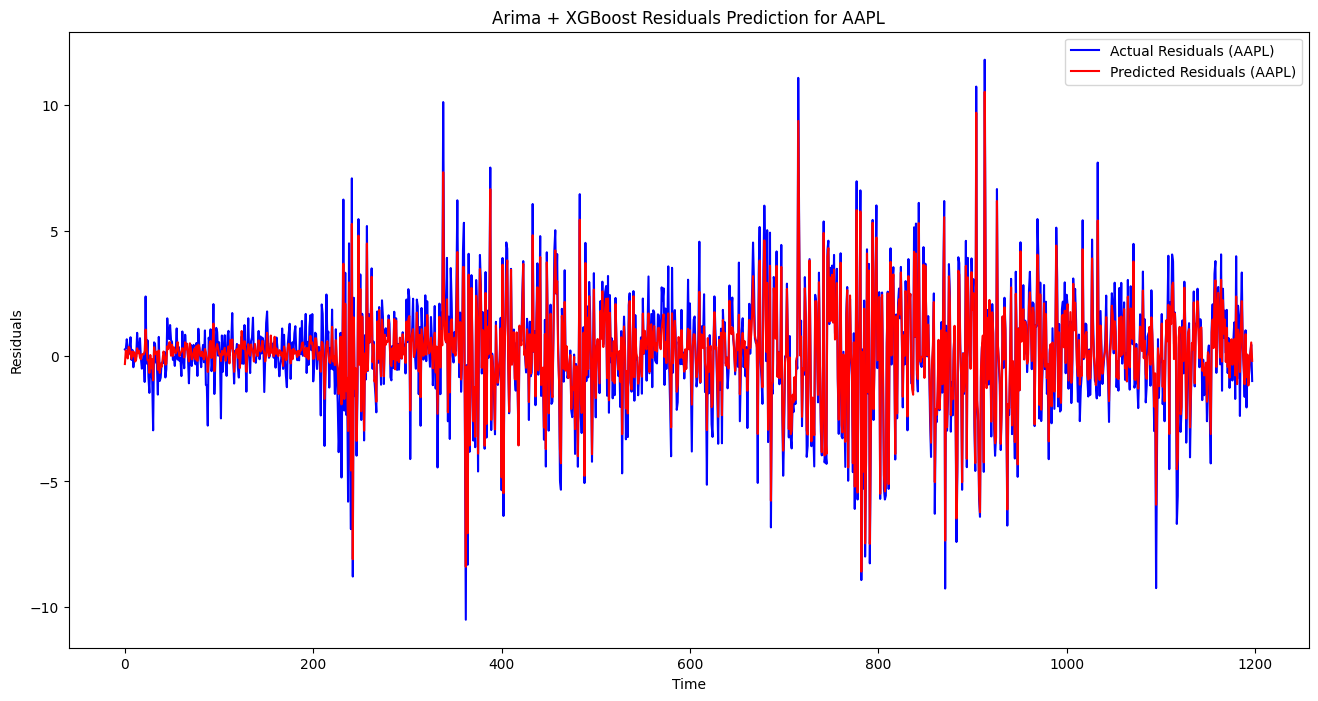

[*********************100%***********************]  1 of 1 completed


Model Performance for AAPL:
Mean Squared Error: 0.45755661971876926
Mean Absolute Error: 0.49888742265236885
R² Score: 0.9231449022528154

Processing stock: GOOGL


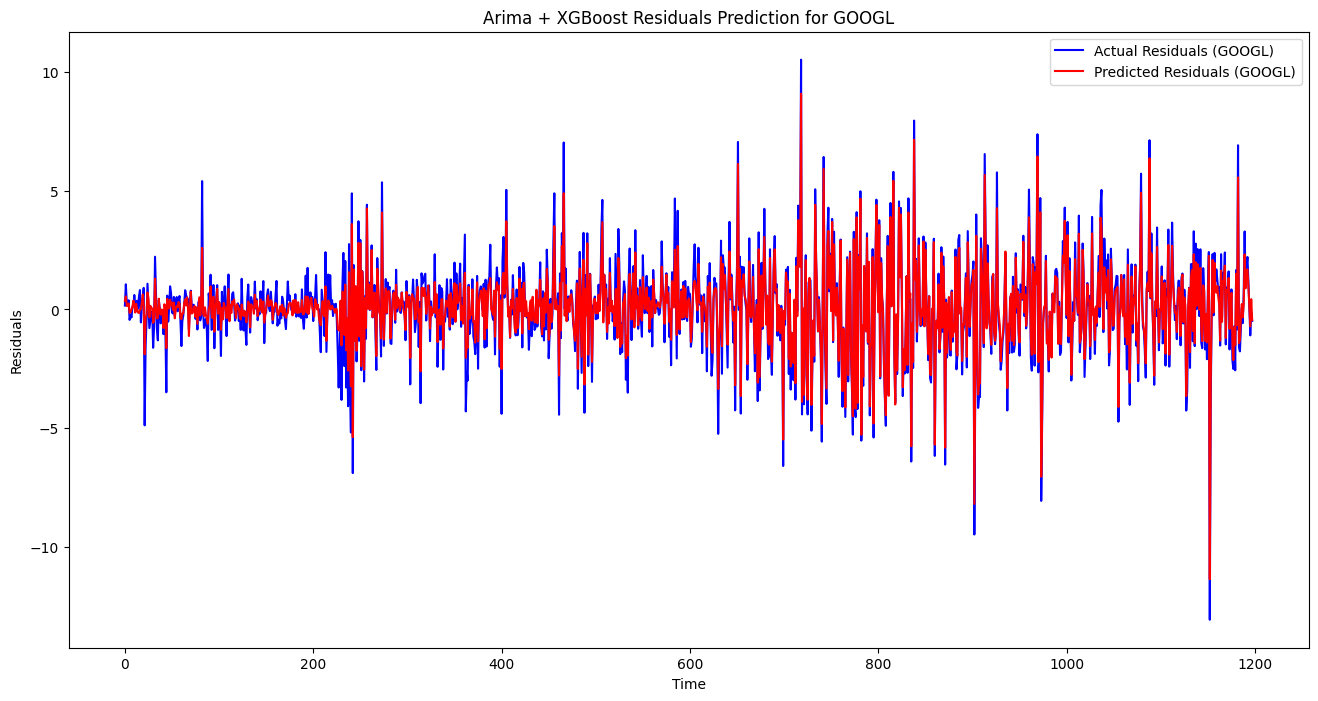

[*********************100%***********************]  1 of 1 completed


Model Performance for GOOGL:
Mean Squared Error: 0.29466169653090774
Mean Absolute Error: 0.39377142675035687
R² Score: 0.9266544584921892

Processing stock: NVDA


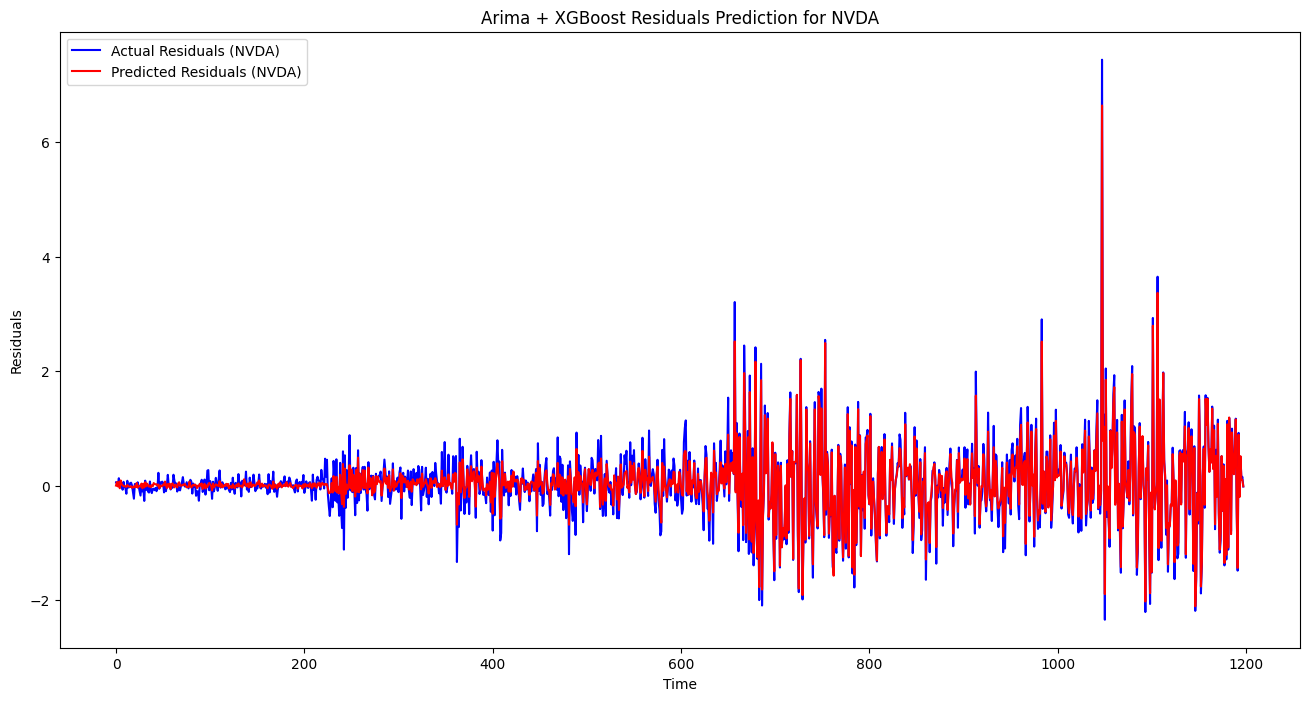

[*********************100%***********************]  1 of 1 completed


Model Performance for NVDA:
Mean Squared Error: 0.02268081785153633
Mean Absolute Error: 0.10755885766138734
R² Score: 0.948930714713206

Processing stock: MSFT


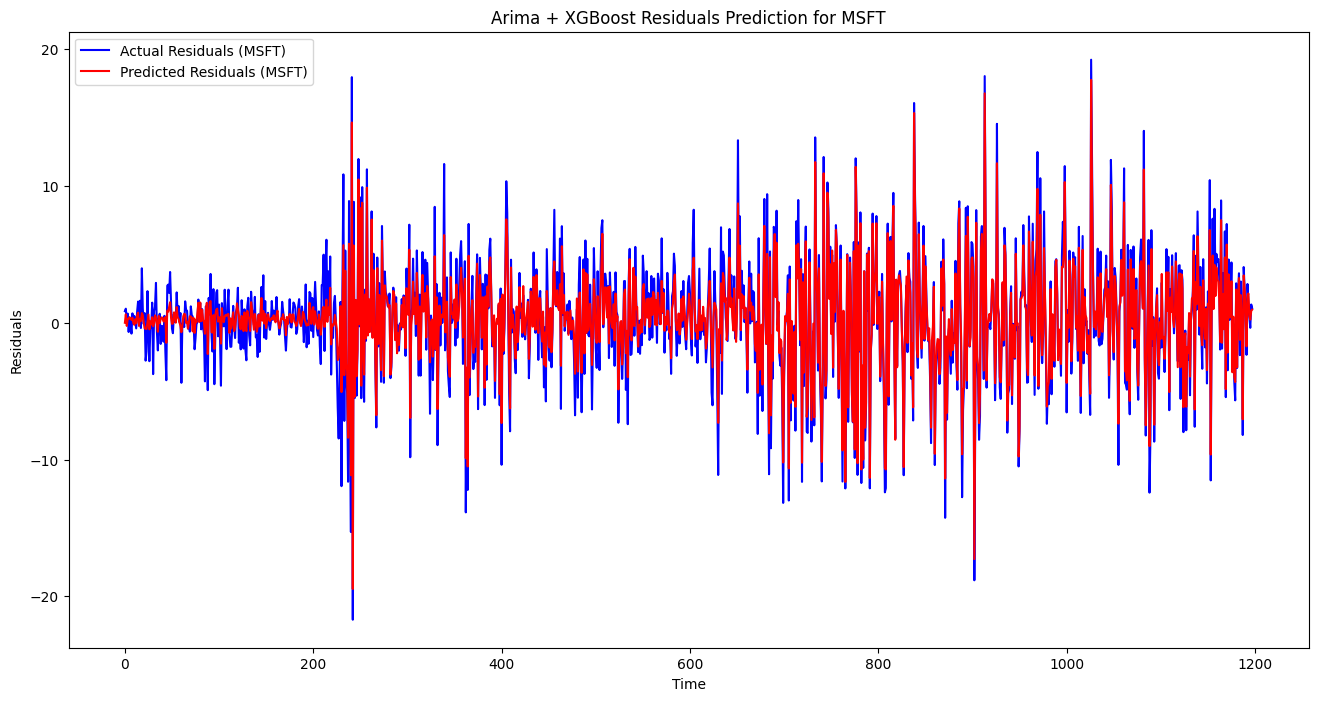

[*********************100%***********************]  1 of 1 completed


Model Performance for MSFT:
Mean Squared Error: 1.6408041066630106
Mean Absolute Error: 0.9504877492016671
R² Score: 0.9172585601548368

Processing stock: TSLA


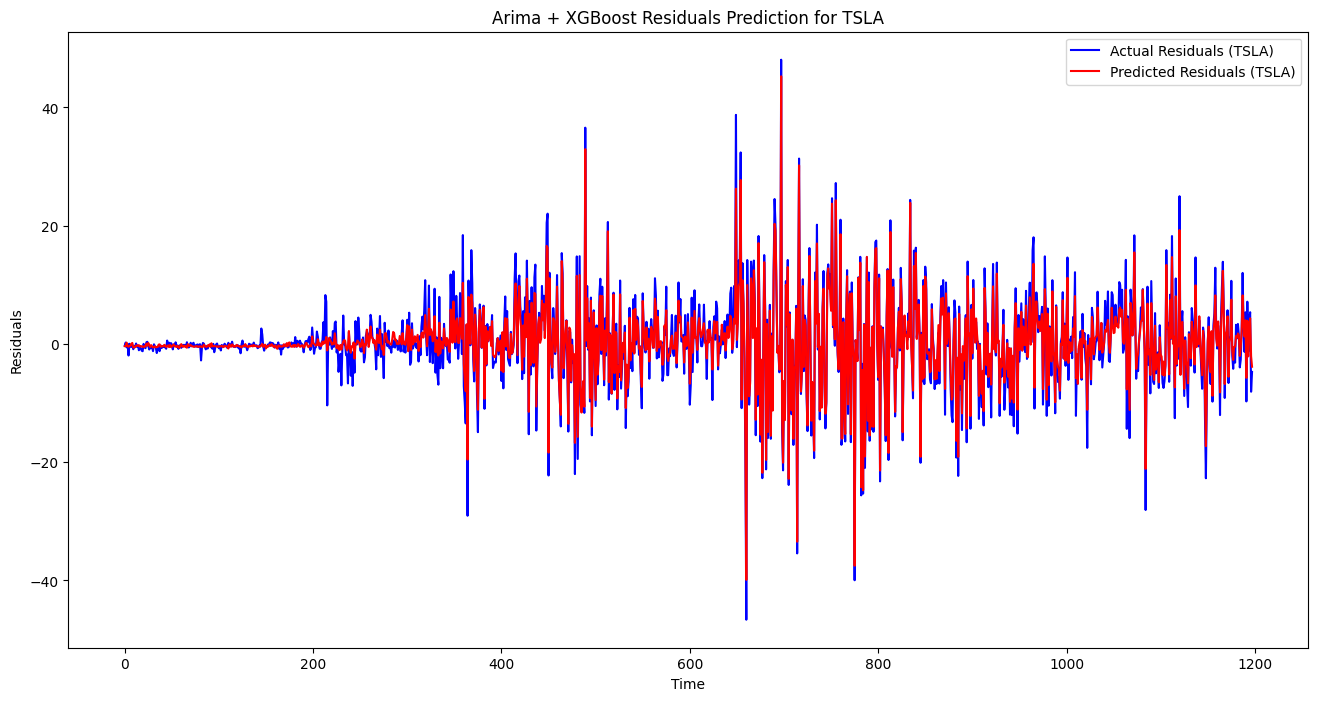

[*********************100%***********************]  1 of 1 completed


Model Performance for TSLA:
Mean Squared Error: 3.8422835074484776
Mean Absolute Error: 1.3574749528088186
R² Score: 0.9371253392701434

Processing stock: AMZN


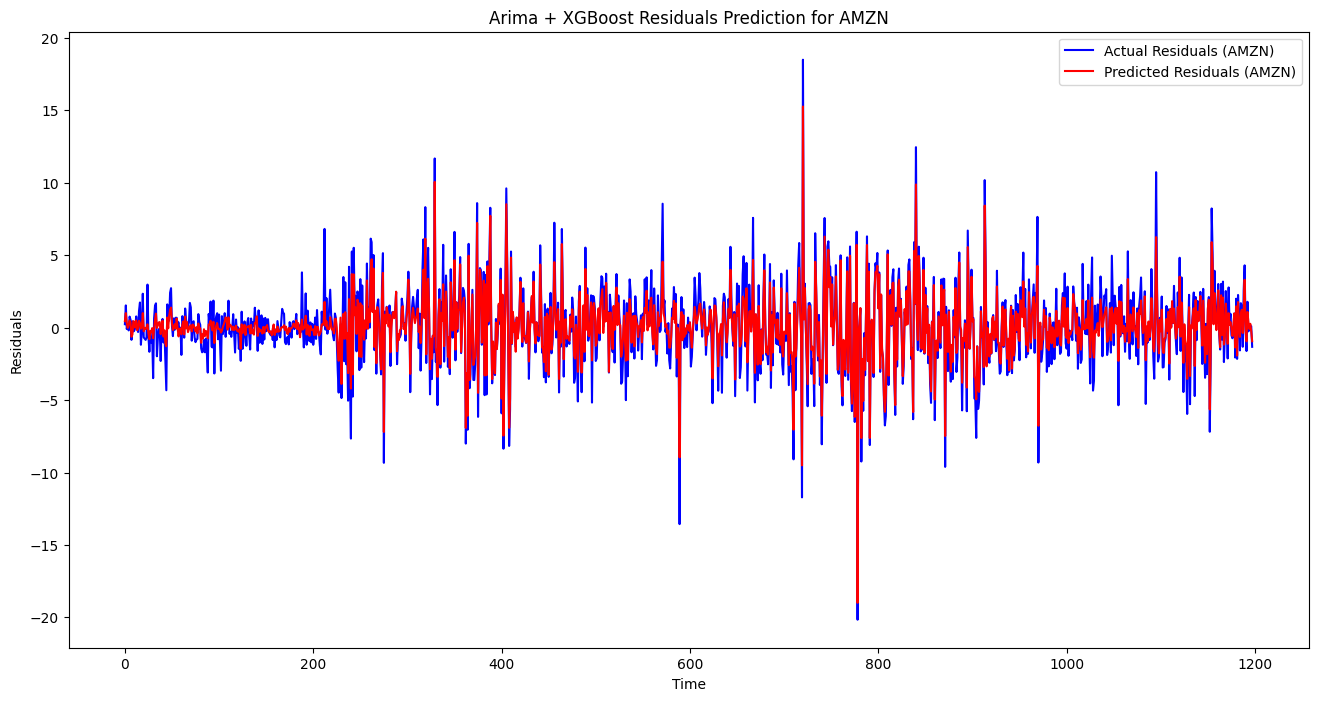

[*********************100%***********************]  1 of 1 completed


Model Performance for AMZN:
Mean Squared Error: 0.9390827818678215
Mean Absolute Error: 0.7171338966154079
R² Score: 0.8858928635379293

Processing stock: META


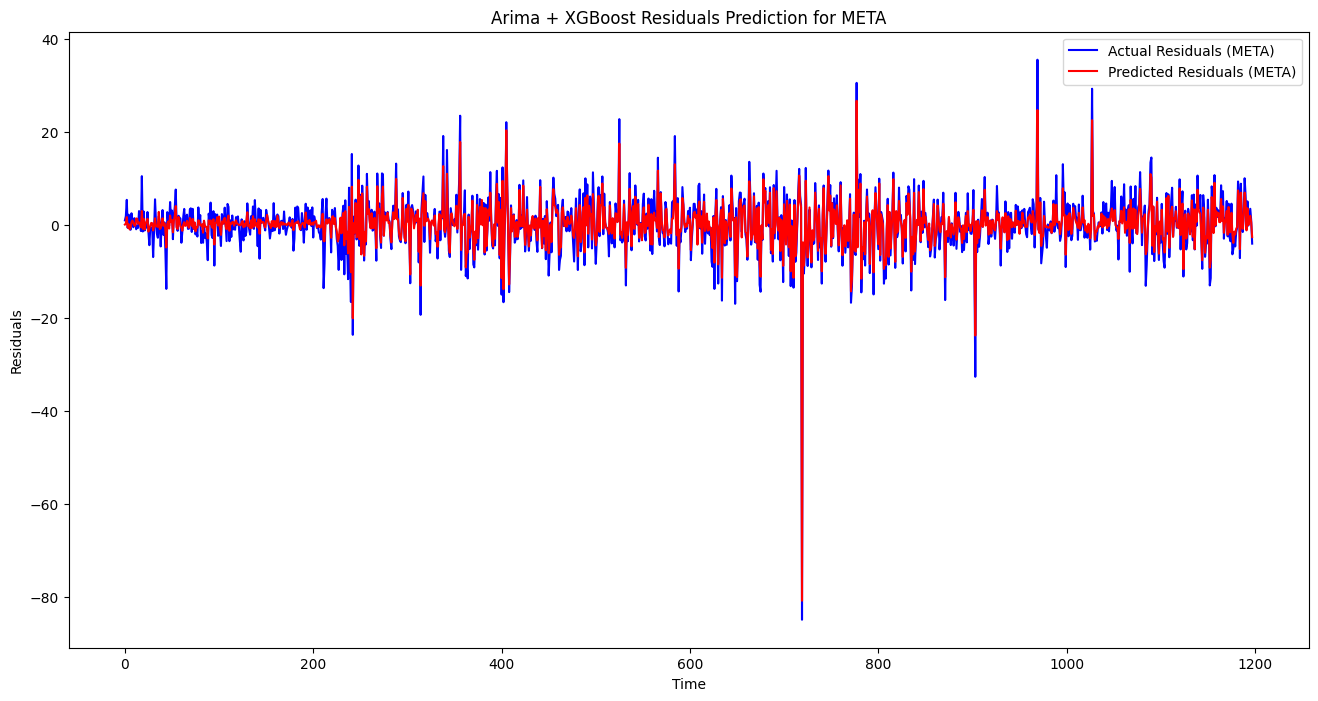


Model Performance for META:
Mean Squared Error: 4.285735004510941
Mean Absolute Error: 1.5340277624936207
R² Score: 0.8870331803143738

Summary of Performance across all stocks:

Average Performance across 7 stocks:
Average MSE: 1.6404006477987803
Average MAE: 0.7941917240262324
Average R²: 0.9180057169622133


In [ ]:
def preprocess_data(data, is_residuals=False):
    if is_residuals:
        # If the data contains residuals, we don't need 'Close' column
        X, y = [], []
        for i in range(60, len(data)):
            X.append(data[i-60:i].values)  # Access values directly
            y.append(data.iloc[i].values)  # Access values directly
        X, y = np.array(X), np.array(y)
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    else:
        # If the data is stock data
        data = data[['Close']].values
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(data)

        X, y = [], []
        for i in range(60, len(scaled_data)):
            X.append(scaled_data[i-60:i, 0])
            y.append(scaled_data[i, 0])

        X, y = np.array(X), np.array(y)
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        return X, y, scaler

    return X, y

def apply_arima(stock_data, order=(2, 0, 1)):
    model = ARIMA(stock_data['Close'], order=order)
    arima_result = model.fit()
    # Output fitted values and residuals
    fitted_values = arima_result.fittedvalues
    residuals = arima_result.resid
    return fitted_values, residuals


# Step 3: Retrain CNN with Residuals as Additional Feature
def build_cnn_with_residuals(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model


# Step 4: XGBoost Model for Residual Prediction
def build_xgboost_model(X_train, y_train):
    model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
    model.fit(X_train, y_train)
    return model

# Function to download and process ARIMA and XGBoost for multiple stocks
def process_multiple_stocks(tickers, start_date, end_date, order=(2, 0, 1)):
    performance_metrics = {}

    for ticker in tickers:
        print(f"\nProcessing stock: {ticker}")

        # Download stock data
        stock_data = download_stock_data(ticker, start_date, end_date)
        X, y, scaler = preprocess_data(stock_data)

        # Apply ARIMA to get fitted values and residuals
        fitted_values, residuals = apply_arima(stock_data, order)

        # Convert residuals to DataFrame for preprocessing
        residuals_df = pd.DataFrame(residuals, columns=['Residuals'])
        X_res, y_res = preprocess_data(residuals_df, is_residuals=True)

        # Reshape X_res for XGBoost
        X_res_2d = X_res.reshape((X_res.shape[0], -1))

        # Build and train the XGBoost model
        xgboost_predictions, xgboost_model = build_xgboost_model(X_res_2d, y_res, X_res_2d, y_res)

        # Plot results for the current stock
        plt.figure(figsize=(16, 8))
        plt.plot(y_res, color='blue', label=f'Actual Residuals ({ticker})')
        plt.plot(xgboost_predictions, color='red', label=f'Predicted Residuals ({ticker})')
        plt.title(f'Arima + XGBoost Residuals Prediction for {ticker}')
        plt.xlabel('Time')
        plt.ylabel('Residuals')
        plt.legend()
        plt.show()

        # Evaluate the XGBoost model and store metrics for each stock
        mse = mean_squared_error(y_res, xgboost_predictions)
        mae = mean_absolute_error(y_res, xgboost_predictions)
        r2 = r2_score(y_res, xgboost_predictions)

        performance_metrics[ticker] = {
            'MSE': mse,
            'MAE': mae,
            'R²': r2
        }

        # Print the performance for the current stock
        print(f'\nModel Performance for {ticker}:')
        print(f'Mean Squared Error: {mse}')
        print(f'Mean Absolute Error: {mae}')
        print(f'R² Score: {r2}')


    # Print performance metrics summary
    print("\nSummary of Performance across all stocks:")

    # Initialize sums for calculating averages
    total_mse = 0
    total_mae = 0
    total_r2 = 0
    num_stocks = len(performance_metrics)

    # Sum the metrics across all stocks
    for ticker, metrics in performance_metrics.items():
        total_mse += metrics['MSE']
        total_mae += metrics['MAE']
        total_r2 += metrics['R²']

    # Calculate the averages
    average_mse = total_mse / num_stocks
    average_mae = total_mae / num_stocks
    average_r2 = total_r2 / num_stocks

    # Print the averages
    print(f"\nAverage Performance across {num_stocks} stocks:")
    print(f"Average MSE: {average_mse}")
    print(f"Average MAE: {average_mae}")
    print(f"Average R²: {average_r2}")



process_multiple_stocks(tickers, start_date, end_date)


The graph displays the results of an ARIMA + XGBoost model integration, where we used ARIMA to model the stock price residuals and XGBoost to predict the residuals.


From the graph, it looks like the model is able to capture the general trend of residuals. The residuals predicted by XGBoost align well with the actual residuals.

The performance starts to degrade slightly in more volatile regions where the residuals fluctuate heavily. This might suggest that the model could be improved, possibly by tuning hyperparameters or by better feature engineering.

[*********************100%***********************]  1 of 1 completed


Processing stock: AAPL



[*********************100%***********************]  1 of 1 completed


Model Performance for AAPL:
Mean Squared Error: 0.45755661971876926
Mean Absolute Error: 0.49888742265236885
R² Score: 0.9231449022528154

Processing stock: GOOGL



[*********************100%***********************]  1 of 1 completed


Model Performance for GOOGL:
Mean Squared Error: 0.29466169653090774
Mean Absolute Error: 0.39377142675035687
R² Score: 0.9266544584921892

Processing stock: NVDA



[*********************100%***********************]  1 of 1 completed


Model Performance for NVDA:
Mean Squared Error: 0.02268081785153633
Mean Absolute Error: 0.10755885766138734
R² Score: 0.948930714713206

Processing stock: MSFT



[*********************100%***********************]  1 of 1 completed


Model Performance for MSFT:
Mean Squared Error: 1.6408041066630106
Mean Absolute Error: 0.9504877492016671
R² Score: 0.9172585601548368

Processing stock: TSLA



[*********************100%***********************]  1 of 1 completed


Model Performance for TSLA:
Mean Squared Error: 3.8422835074484776
Mean Absolute Error: 1.3574749528088186
R² Score: 0.9371253392701434

Processing stock: AMZN



[*********************100%***********************]  1 of 1 completed


Model Performance for AMZN:
Mean Squared Error: 0.9390827818678215
Mean Absolute Error: 0.7171338966154079
R² Score: 0.8858928635379293

Processing stock: META



Model Performance for META:
Mean Squared Error: 4.285735004510941
Mean Absolute Error: 1.5340277624936207
R² Score: 0.8870331803143738


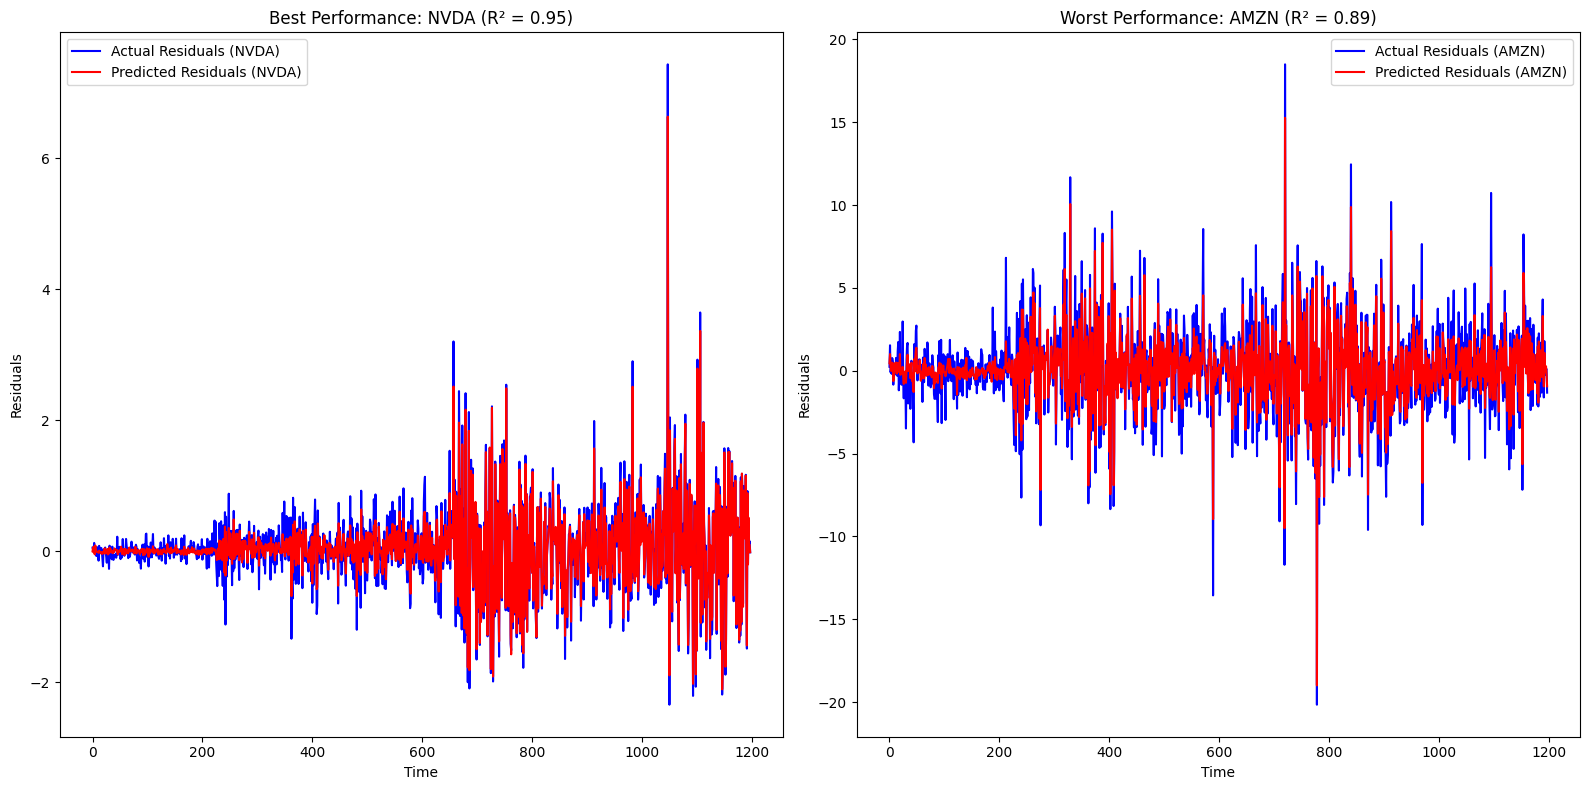


Summary of Performance across all stocks:

Average Performance across 7 stocks:
Average MSE: 1.6404006477987803
Average MAE: 0.7941917240262324
Average R²: 0.9180057169622133


In [24]:
def apply_arima(stock_data, order=(2, 0, 1)):
    model = ARIMA(stock_data['Close'], order=order)
    arima_result = model.fit()
    # Output fitted values and residuals
    fitted_values = arima_result.fittedvalues
    residuals = arima_result.resid
    return fitted_values, residuals


# Step 3: Retrain CNN with Residuals as Additional Feature
def build_cnn_with_residuals(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

def build_xgboost_model(X_train, y_train, X_test, y_test):
    model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return predictions, model


# Function to download and process ARIMA and XGBoost for multiple stocks and plot best/worst performance
def process_multiple_stocks(tickers, start_date, end_date, order=(2, 0, 1)):
    performance_metrics = {}

    for ticker in tickers:
        print(f"\nProcessing stock: {ticker}")

        # Download stock data
        stock_data = download_stock_data(ticker, start_date, end_date)
        X, y, scaler = preprocess_data(stock_data)

        # Apply ARIMA to get fitted values and residuals
        fitted_values, residuals = apply_arima(stock_data, order)

        # Convert residuals to DataFrame for preprocessing
        residuals_df = pd.DataFrame(residuals, columns=['Residuals'])
        X_res, y_res = preprocess_data(residuals_df, is_residuals=True)

        # Reshape X_res for XGBoost
        X_res_2d = X_res.reshape((X_res.shape[0], -1))

        # Build and train the XGBoost model
        xgboost_predictions, xgboost_model = build_xgboost_model(X_res_2d, y_res, X_res_2d, y_res)

        # Evaluate the XGBoost model and store metrics for each stock
        mse = mean_squared_error(y_res, xgboost_predictions)
        mae = mean_absolute_error(y_res, xgboost_predictions)
        r2 = r2_score(y_res, xgboost_predictions)

        performance_metrics[ticker] = {
            'MSE': mse,
            'MAE': mae,
            'R²': r2,
            'y_res': y_res,  # Save actual residuals for plotting later
            'xgboost_predictions': xgboost_predictions  # Save predictions
        }

        # Print the performance for the current stock
        print(f'\nModel Performance for {ticker}:')
        print(f'Mean Squared Error: {mse}')
        print(f'Mean Absolute Error: {mae}')
        print(f'R² Score: {r2}')

    # Identify the best and worst predictions based on R² score
    best_ticker = max(performance_metrics, key=lambda x: performance_metrics[x]['R²'])
    worst_ticker = min(performance_metrics, key=lambda x: performance_metrics[x]['R²'])

    # Get corresponding residuals and predictions for the best and worst performing stocks
    best_actual = performance_metrics[best_ticker]['y_res']
    best_pred = performance_metrics[best_ticker]['xgboost_predictions']
    worst_actual = performance_metrics[worst_ticker]['y_res']
    worst_pred = performance_metrics[worst_ticker]['xgboost_predictions']

    # Create 1x2 plot for best and worst performance
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))

    # Best performance
    axs[0].plot(best_actual, color='blue', label=f'Actual Residuals ({best_ticker})')
    axs[0].plot(best_pred, color='red', label=f'Predicted Residuals ({best_ticker})')
    axs[0].set_title(f'Best Performance: {best_ticker} (R² = {performance_metrics[best_ticker]["R²"]:.2f})')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Residuals')
    axs[0].legend()

    # Worst performance
    axs[1].plot(worst_actual, color='blue', label=f'Actual Residuals ({worst_ticker})')
    axs[1].plot(worst_pred, color='red', label=f'Predicted Residuals ({worst_ticker})')
    axs[1].set_title(f'Worst Performance: {worst_ticker} (R² = {performance_metrics[worst_ticker]["R²"]:.2f})')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Residuals')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

    # Print performance metrics summary
    print("\nSummary of Performance across all stocks:")

    # Initialize sums for calculating averages
    total_mse = 0
    total_mae = 0
    total_r2 = 0
    num_stocks = len(performance_metrics)

    # Sum the metrics across all stocks
    for ticker, metrics in performance_metrics.items():
        total_mse += metrics['MSE']
        total_mae += metrics['MAE']
        total_r2 += metrics['R²']

    # Calculate the averages
    average_mse = total_mse / num_stocks
    average_mae = total_mae / num_stocks
    average_r2 = total_r2 / num_stocks

    # Print the averages
    print(f"\nAverage Performance across {num_stocks} stocks:")
    print(f"Average MSE: {average_mse}")
    print(f"Average MAE: {average_mae}")
    print(f"Average R²: {average_r2}")

process_multiple_stocks(tickers, start_date, end_date)


### **CNN Improvment with ARIMA residuals**

[*********************100%***********************]  1 of 1 completed


Processing stock: AAPL


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%***********************]  1 of 1 completed


Performance for AAPL:
Mean Squared Error (MSE): 95.78229903951238
Mean Absolute Error (MAE): 9.009446779886881
R² Score: 0.5909379702450263

Processing stock: GOOGL


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Performance for GOOGL:
Mean Squared Error (MSE): 16.468958102855687
Mean Absolute Error (MAE): 3.305731932322184
R² Score: 0.9294299400129322

Processing stock: NVDA


[*********************100%***********************]  1 of 1 completed


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[*********************100%***********************]  1 of 1 completed


Performance for NVDA:
Mean Squared Error (MSE): 10.466117844446945
Mean Absolute Error (MAE): 2.6979942957560223
R² Score: 0.8964349919749229

Processing stock: MSFT


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%***********************]  1 of 1 completed


Performance for MSFT:
Mean Squared Error (MSE): 86.09359251651139
Mean Absolute Error (MAE): 7.648204930623375
R² Score: 0.9407405151539899

Processing stock: TSLA


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Performance for TSLA:
Mean Squared Error (MSE): 124.93522199712412
Mean Absolute Error (MAE): 8.890431658426921
R² Score: 0.9104609624033048

Processing stock: AMZN


[*********************100%***********************]  1 of 1 completed


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%***********************]  1 of 1 completed


Performance for AMZN:
Mean Squared Error (MSE): 22.64699218998576
Mean Absolute Error (MAE): 3.9175893783569338
R² Score: 0.9308137092569717

Processing stock: META


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Performance for META:
Mean Squared Error (MSE): 62.180509393206236
Mean Absolute Error (MAE): 5.691687393188475
R² Score: 0.9817046296750599

Average Performance across all stocks:
Average MSE: 59.796241583377515
Average MAE: 5.880155195508685
Average R²: 0.8829318169603155


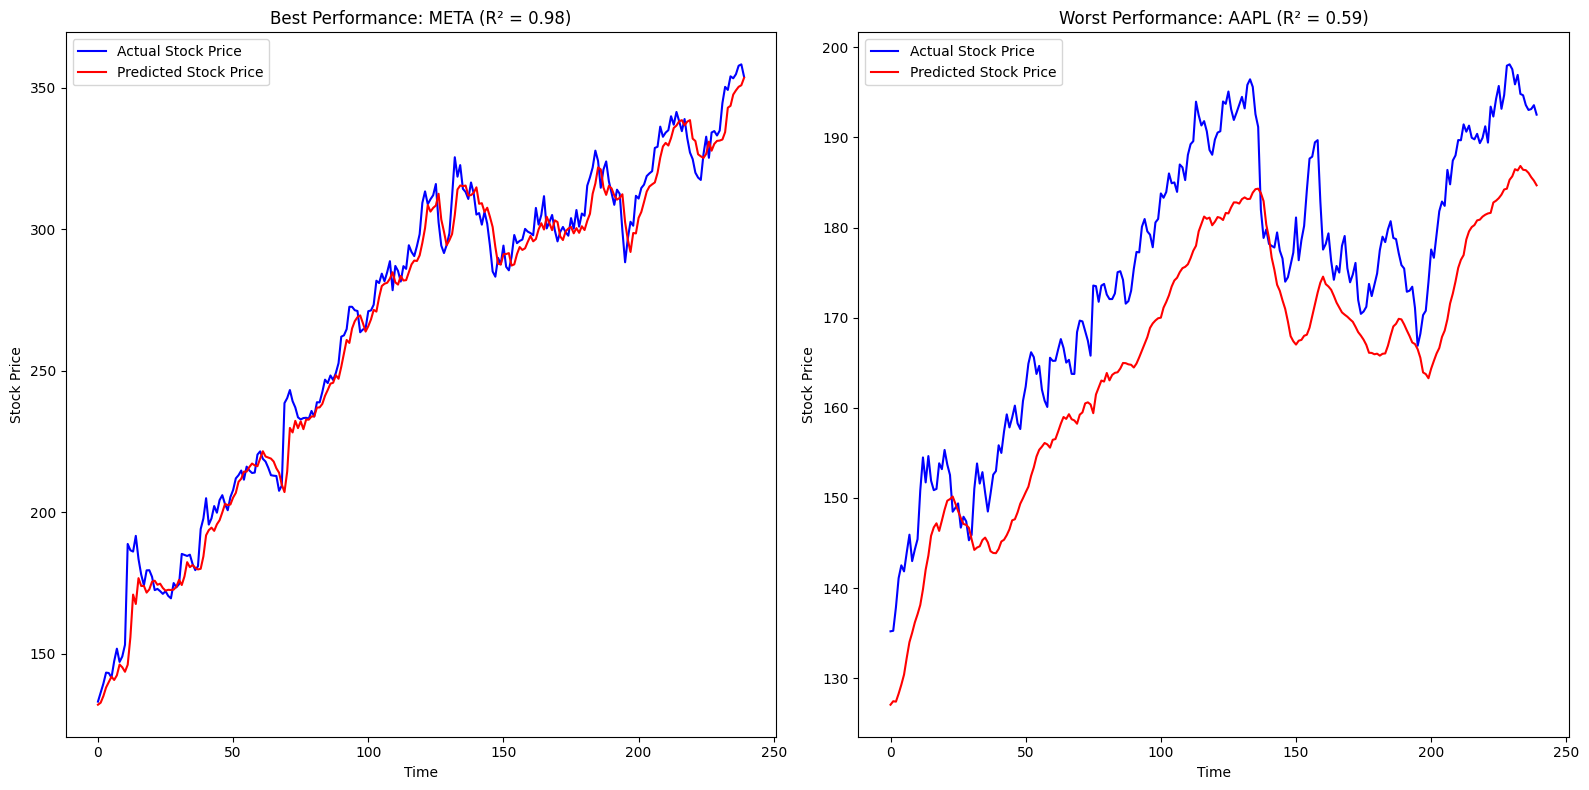

In [47]:
def train_and_evaluate_combined_model(model, X_train, y_train, X_test, y_test, scaler):
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    end_time = time.time()
    training_time = end_time - start_time
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=0)

    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(y_test_scaled, predictions)
    mae = mean_absolute_error(y_test_scaled, predictions)
    r2 = r2_score(y_test_scaled, predictions)

    return mse, mae, r2


# Process multiple stocks and plot best/worst performance
def process_multiple_stocks(tickers, start_date, end_date):
    performance_metrics = []

    for ticker in tickers:
        print(f"\nProcessing stock: {ticker}")

        # Download and preprocess data
        stock_data = download_stock_data(ticker, start_date, end_date)
        X, y, scaler = preprocess_data(stock_data)

        # Apply ARIMA and get residuals
        _, residuals = apply_arima(stock_data)

        # Prepare residuals for XGBoost training
        residuals_df = pd.DataFrame(residuals, columns=['Residuals'])
        X_residuals, y_residuals = preprocess_data(residuals_df, is_residuals=True)

        # Split residuals into training and test sets
        split = int(0.8 * len(X_residuals))
        X_train_residuals, X_test_residuals = X_residuals[:split], X_residuals[split:]
        y_train_residuals, y_test_residuals = y_residuals[:split], y_residuals[split:]

        # Train XGBoost model on residuals using the custom build_xgboost_model
        xgboost_predictions, xgboost_model = build_xgboost_model(
            X_train_residuals.reshape((X_train_residuals.shape[0], -1)),
            y_train_residuals,
            X_test_residuals.reshape((X_test_residuals.shape[0], -1)),
            y_test_residuals
        )

        # Combine residuals with stock data
        X_combined = combine_residuals_with_data(X, residuals)

        # Split combined data into training and test sets
        split = int(0.8 * len(X_combined))
        X_train_combined, X_test_combined = X_combined[:split], X_combined[split:]
        y_train, y_test = y[:split], y[split:]

        # If X_train_combined is 2D, reshape it to 3D (samples, features, 1)
        if len(X_train_combined.shape) == 2:
            X_train_combined = X_train_combined.reshape(X_train_combined.shape[0], X_train_combined.shape[1], 1)

        if len(X_test_combined.shape) == 2:
            X_test_combined = X_test_combined.reshape(X_test_combined.shape[0], X_test_combined.shape[1], 1)

        # Now, build the CNN model with the reshaped input
        cnn_model_with_residuals = build_cnn_with_residuals((X_train_combined.shape[1], X_train_combined.shape[2]))
        mse, mae, r2 = train_and_evaluate_combined_model(cnn_model_with_residuals, X_train_combined, y_train, X_test_combined, y_test, scaler)

        # Inverse transform the actual stock prices (y_test) and predictions
        y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))
        predictions_scaled = scaler.inverse_transform(cnn_model_with_residuals.predict(X_test_combined))

        # Store performance metrics and model results
        performance_metrics.append({
            'ticker': ticker,
            'mse': mse,
            'mae': mae,
            'r2': r2,
            'y_test': y_test_scaled.flatten(),  # Inverse transformed
            'predictions': predictions_scaled.flatten()  # Inverse transformed
        })

        print(f"\nPerformance for {ticker}:")
        print(f"Mean Squared Error (MSE): {mse}")
        print(f"Mean Absolute Error (MAE): {mae}")
        print(f"R² Score: {r2}")

    # Calculate and print average performance across all stocks
    avg_mse = sum([m['mse'] for m in performance_metrics]) / len(performance_metrics)
    avg_mae = sum([m['mae'] for m in performance_metrics]) / len(performance_metrics)
    avg_r2 = sum([m['r2'] for m in performance_metrics]) / len(performance_metrics)

    print("\nAverage Performance across all stocks:")
    print(f"Average MSE: {avg_mse}")
    print(f"Average MAE: {avg_mae}")
    print(f"Average R²: {avg_r2}")

    # Find the best and worst performing stocks based on R² score
    best_stock = max(performance_metrics, key=lambda x: x['r2'])
    worst_stock = min(performance_metrics, key=lambda x: x['r2'])

    # Plot best and worst performance
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))

    # Best stock plot
    axs[0].plot(best_stock['y_test'], color='blue', label='Actual Stock Price')
    axs[0].plot(best_stock['predictions'], color='red', label='Predicted Stock Price')
    axs[0].set_title(f'Best Performance: {best_stock["ticker"]} (R² = {best_stock["r2"]:.2f})')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Stock Price')
    axs[0].legend()

    # Worst stock plot
    axs[1].plot(worst_stock['y_test'], color='blue', label='Actual Stock Price')
    axs[1].plot(worst_stock['predictions'], color='red', label='Predicted Stock Price')
    axs[1].set_title(f'Worst Performance: {worst_stock["ticker"]} (R² = {worst_stock["r2"]:.2f})')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Stock Price')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

process_multiple_stocks(tickers, start_date, end_date)


[*********************100%***********************]  1 of 1 completed


Processing stock: AAPL


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%***********************]  1 of 1 completed


Performance for AAPL:
Mean Squared Error (MSE): 92.54508183027454
Mean Absolute Error (MAE): 8.576591491699219
R² Score: 0.6047633080751642

Processing stock: GOOGL


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[*********************100%***********************]  1 of 1 completed


Performance for GOOGL:
Mean Squared Error (MSE): 15.842541692683398
Mean Absolute Error (MAE): 3.2314261118570964
R² Score: 0.9321141561829326

Processing stock: NVDA


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[*********************100%***********************]  1 of 1 completed


Performance for NVDA:
Mean Squared Error (MSE): 7.998448034604568
Mean Absolute Error (MAE): 2.2673649390538535
R² Score: 0.9208532383063611

Processing stock: MSFT


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Performance for MSFT:
Mean Squared Error (MSE): 83.73743458579222
Mean Absolute Error (MAE): 7.513584391276043
R² Score: 0.9423622932806662

Processing stock: TSLA


[*********************100%***********************]  1 of 1 completed


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%***********************]  1 of 1 completed


Performance for TSLA:
Mean Squared Error (MSE): 102.85730631978485
Mean Absolute Error (MAE): 8.06321217219035
R² Score: 0.9262838447761832

Processing stock: AMZN


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Performance for AMZN:
Mean Squared Error (MSE): 17.208883367590655
Mean Absolute Error (MAE): 3.3440699577331543
R² Score: 0.9474270667802204

Processing stock: META


[*********************100%***********************]  1 of 1 completed


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Performance for META:
Mean Squared Error (MSE): 65.18635588866985
Mean Absolute Error (MAE): 5.901737658182779
R² Score: 0.9808202195068081

Average Performance across all stocks:
Average MSE: 55.053721674200006
Average MAE: 5.5568552459989276
Average R²: 0.8935177324154766


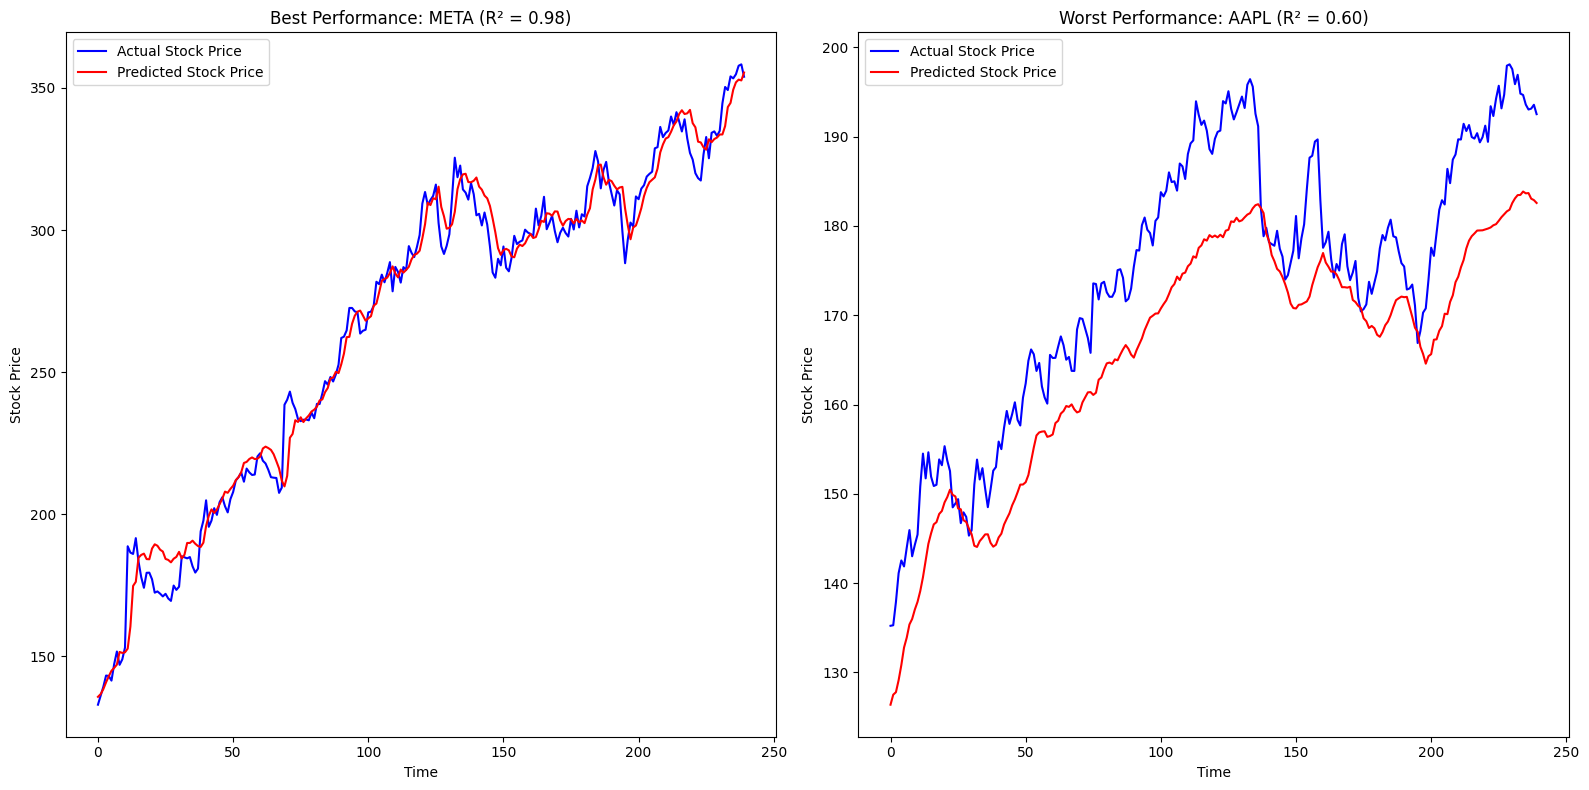

In [52]:
def build_cnn_with_residuals(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

def build_xgboost_model(X_train, y_train, X_test, y_test):
    model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return predictions, model

# Step 5: Combine Residuals into Dataset
def combine_residuals_with_data(X, residuals):
    # Ensure residuals are a 2D array with one column
    if isinstance(residuals, pd.Series):
        residuals = residuals.values
    residuals = residuals.reshape(-1, 1)

    # Flatten X if it has more than 2 dimensions (e.g., from time series data)
    if len(X.shape) == 3:
        # Flatten the last two dimensions or reshape based on the context of your data
        X = X.reshape(X.shape[0], -1)  # Flattening X to 2D

    # Trim the larger array to the smaller array's length
    min_length = min(X.shape[0], residuals.shape[0])
    X = X[:min_length]
    residuals = residuals[:min_length]

    # Concatenate along the last axis (features)
    X_combined = np.concatenate((X, residuals), axis=1)

    return X_combined


def train_and_evaluate_combined_model(model, X_train, y_train, X_test, y_test, scaler):
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    end_time = time.time()
    training_time = end_time - start_time
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=0)

    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(y_test_scaled, predictions)
    mae = mean_absolute_error(y_test_scaled, predictions)
    r2 = r2_score(y_test_scaled, predictions)

    return mse, mae, r2



# Process multiple stocks and plot best/worst performance
def process_multiple_stocks(tickers, start_date, end_date):
    performance_metrics = []

    for ticker in tickers:
        print(f"\nProcessing stock: {ticker}")

        # Download and preprocess data
        stock_data = download_stock_data(ticker, start_date, end_date)
        X, y, scaler = preprocess_data(stock_data)

        # Apply ARIMA and get residuals
        _, residuals = apply_arima(stock_data)

        # Prepare residuals for XGBoost training
        residuals_df = pd.DataFrame(residuals, columns=['Residuals'])
        X_residuals, y_residuals = preprocess_data(residuals_df, is_residuals=True)

        # Split residuals into training and test sets
        split = int(0.8 * len(X_residuals))
        X_train_residuals, X_test_residuals = X_residuals[:split], X_residuals[split:]
        y_train_residuals, y_test_residuals = y_residuals[:split], y_residuals[split:]

        # Train XGBoost model on residuals using the custom build_xgboost_model
        xgboost_predictions, xgboost_model = build_xgboost_model(
            X_train_residuals.reshape((X_train_residuals.shape[0], -1)),
            y_train_residuals,
            X_test_residuals.reshape((X_test_residuals.shape[0], -1)),
            y_test_residuals
        )

        # Combine residuals with stock data
        X_combined = combine_residuals_with_data(X, residuals)

        # Split combined data into training and test sets
        split = int(0.8 * len(X_combined))
        X_train_combined, X_test_combined = X_combined[:split], X_combined[split:]
        y_train, y_test = y[:split], y[split:]

        # If X_train_combined is 2D, reshape it to 3D (samples, features, 1)
        if len(X_train_combined.shape) == 2:
            X_train_combined = X_train_combined.reshape(X_train_combined.shape[0], X_train_combined.shape[1], 1)

        if len(X_test_combined.shape) == 2:
            X_test_combined = X_test_combined.reshape(X_test_combined.shape[0], X_test_combined.shape[1], 1)

        # Now, build the CNN model with the reshaped input
        cnn_model_with_residuals = build_cnn_with_residuals((X_train_combined.shape[1], X_train_combined.shape[2]))
        mse, mae, r2 = train_and_evaluate_combined_model(cnn_model_with_residuals, X_train_combined, y_train, X_test_combined, y_test, scaler)

        # Inverse transform the actual stock prices (y_test) and predictions
        y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))
        predictions_scaled = scaler.inverse_transform(cnn_model_with_residuals.predict(X_test_combined))

        # Store performance metrics and model results
        performance_metrics.append({
            'ticker': ticker,
            'mse': mse,
            'mae': mae,
            'r2': r2,
            'y_test': y_test_scaled.flatten(),  # Inverse transformed
            'predictions': predictions_scaled.flatten()  # Inverse transformed
        })

        print(f"\nPerformance for {ticker}:")
        print(f"Mean Squared Error (MSE): {mse}")
        print(f"Mean Absolute Error (MAE): {mae}")
        print(f"R² Score: {r2}")

    # Calculate and print average performance across all stocks
    avg_mse = sum([m['mse'] for m in performance_metrics]) / len(performance_metrics)
    avg_mae = sum([m['mae'] for m in performance_metrics]) / len(performance_metrics)
    avg_r2 = sum([m['r2'] for m in performance_metrics]) / len(performance_metrics)

    print("\nAverage Performance across all stocks:")
    print(f"Average MSE: {avg_mse}")
    print(f"Average MAE: {avg_mae}")
    print(f"Average R²: {avg_r2}")

    # Find the best and worst performing stocks based on R² score
    best_stock = max(performance_metrics, key=lambda x: x['r2'])
    worst_stock = min(performance_metrics, key=lambda x: x['r2'])

    # Plot best and worst performance
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))

    # Best stock plot
    axs[0].plot(best_stock['y_test'], color='blue', label='Actual Stock Price')
    axs[0].plot(best_stock['predictions'], color='red', label='Predicted Stock Price')
    axs[0].set_title(f'Best Performance: {best_stock["ticker"]} (R² = {best_stock["r2"]:.2f})')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Stock Price')
    axs[0].legend()

    # Worst stock plot
    axs[1].plot(worst_stock['y_test'], color='blue', label='Actual Stock Price')
    axs[1].plot(worst_stock['predictions'], color='red', label='Predicted Stock Price')
    axs[1].set_title(f'Worst Performance: {worst_stock["ticker"]} (R² = {worst_stock["r2"]:.2f})')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Stock Price')
    axs[1].legend()

    plt.tight_layout()
    plt.show()
    tf.keras.utils.plot_model(cnn_model_with_residuals,to_file='cnn_model_with_residuals.png', show_shapes=True, show_layer_names=True)

process_multiple_stocks(tickers, start_date, end_date)


[*********************100%***********************]  1 of 1 completed


Processing stock: AAPL


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%***********************]  1 of 1 completed


CNN Model MSE Confidence Interval for AAPL: (75.56006636386965, 91.89164017463935)
CNN Model R² Confidence Interval for AAPL: (0.569777666415584, 0.6985161676735581)

Processing stock: GOOGL


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%***********************]  1 of 1 completed


CNN Model MSE Confidence Interval for GOOGL: (14.091357086448276, 19.281487029839624)
CNN Model R² Confidence Interval for GOOGL: (0.9130217290653599, 0.9418333978648397)

Processing stock: NVDA


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%***********************]  1 of 1 completed


CNN Model MSE Confidence Interval for NVDA: (8.473393745846648, 11.263147818931204)
CNN Model R² Confidence Interval for NVDA: (0.8812741727447271, 0.919728499898545)

Processing stock: MSFT


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%***********************]  1 of 1 completed


CNN Model MSE Confidence Interval for MSFT: (121.62910609835008, 161.34455567507905)
CNN Model R² Confidence Interval for MSFT: (0.8817744656380966, 0.9202483296041843)

Processing stock: TSLA


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[*********************100%***********************]  1 of 1 completed


CNN Model MSE Confidence Interval for TSLA: (125.52286139876645, 177.33698635652763)
CNN Model R² Confidence Interval for TSLA: (0.8654995521853862, 0.9127644757441038)

Processing stock: AMZN


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%***********************]  1 of 1 completed


CNN Model MSE Confidence Interval for AMZN: (12.329902253595698, 18.359507367569822)
CNN Model R² Confidence Interval for AMZN: (0.9401287503199609, 0.9632845040829957)

Processing stock: META


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

CNN Model MSE Confidence Interval for META: (57.07860914767036, 88.10370856496455)
CNN Model R² Confidence Interval for META: (0.9727035550871075, 0.9835043334727884)

Mean Confidence Interval Across All Stocks:
Mean MSE Confidence Interval: [59.24075658 81.08300471]
Mean R² Confidence Interval: [0.86059713 0.9056971 ]


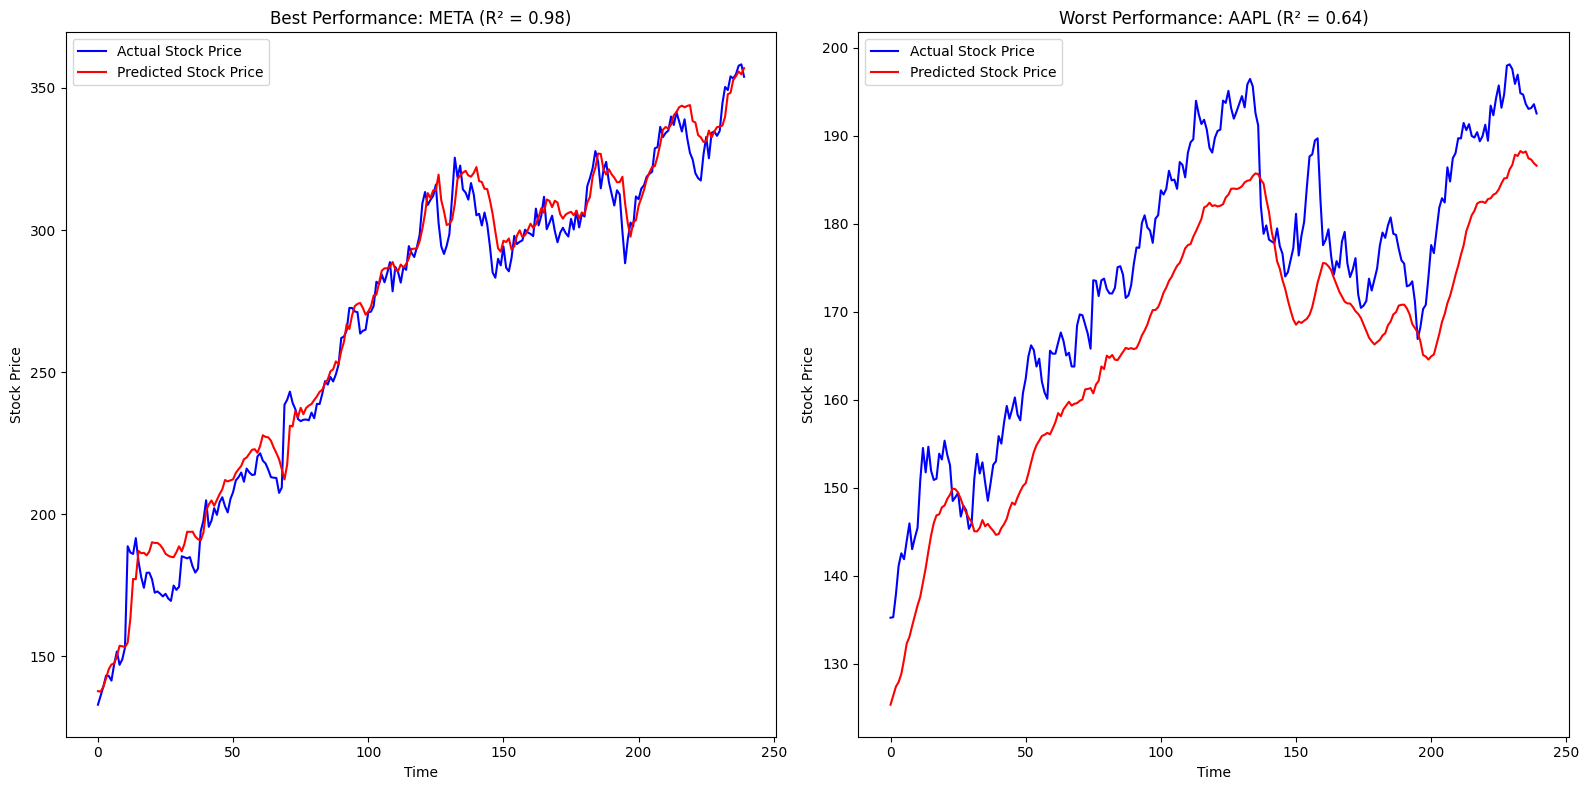

In [54]:
from sklearn.utils import resample

# Define a function to calculate bootstrap confidence intervals
def bootstrap_ci(model_predictions, actual_values, n_iterations=1000, ci_level=95):
    mse_bootstrap = []
    r2_bootstrap = []

    # Bootstrap iterations
    for i in range(n_iterations):
        # Resample with replacement
        actual_resampled, pred_resampled = resample(actual_values, model_predictions)

        # Calculate MSE and R² for resampled data
        mse = mean_squared_error(actual_resampled, pred_resampled)
        r2 = r2_score(actual_resampled, pred_resampled)

        # Store results
        mse_bootstrap.append(mse)
        r2_bootstrap.append(r2)

    # Calculate confidence intervals
    lower_mse = np.percentile(mse_bootstrap, (100 - ci_level) / 2)
    upper_mse = np.percentile(mse_bootstrap, 100 - (100 - ci_level) / 2)

    lower_r2 = np.percentile(r2_bootstrap, (100 - ci_level) / 2)
    upper_r2 = np.percentile(r2_bootstrap, 100 - (100 - ci_level) / 2)

    return (lower_mse, upper_mse), (lower_r2, upper_r2)


def process_multiple_stocks_with_bootstrap(tickers, start_date, end_date):
    mse_ci_all_stocks = []
    r2_ci_all_stocks = []
    performance_metrics = []

    for ticker in tickers:
        print(f"\nProcessing stock: {ticker}")

        # Download and preprocess data
        stock_data = download_stock_data(ticker, start_date, end_date)
        X, y, scaler = preprocess_data(stock_data)

        # Apply ARIMA and get residuals
        _, residuals = apply_arima(stock_data)

        # Combine residuals with stock data
        X_combined = combine_residuals_with_data(X, residuals)

        # Split combined data into training and test sets
        split = int(0.8 * len(X_combined))
        X_train_combined, X_test_combined = X_combined[:split], X_combined[split:]
        y_train, y_test = y[:split], y[split:]

        # Reshape data for CNN model
        if len(X_train_combined.shape) == 2:
            X_train_combined = X_train_combined.reshape(X_train_combined.shape[0], X_train_combined.shape[1], 1)
        if len(X_test_combined.shape) == 2:
            X_test_combined = X_test_combined.reshape(X_test_combined.shape[0], X_test_combined.shape[1], 1)

        # Build and train the CNN model with residuals
        cnn_model_with_residuals = build_cnn_with_residuals((X_train_combined.shape[1], X_train_combined.shape[2]))
        mse, mae, r2 = train_and_evaluate_combined_model(cnn_model_with_residuals, X_train_combined, y_train, X_test_combined, y_test, scaler)

        # Inverse transform actual and predicted values
        y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
        predictions_scaled = scaler.inverse_transform(cnn_model_with_residuals.predict(X_test_combined)).flatten()

        # Calculate bootstrap confidence intervals for the current stock
        mse_ci, r2_ci = bootstrap_ci(predictions_scaled, y_test_scaled)

        # Store confidence intervals
        mse_ci_all_stocks.append(mse_ci)
        r2_ci_all_stocks.append(r2_ci)

        print(f'\nCNN Model MSE Confidence Interval for {ticker}: {mse_ci}')
        print(f'CNN Model R² Confidence Interval for {ticker}: {r2_ci}')

        # Store performance metrics and model results
        performance_metrics.append({
            'ticker': ticker,
            'mse': mse,
            'mae': mae,
            'r2': r2,
            'y_test': y_test_scaled,
            'predictions': predictions_scaled
        })

    # Calculate the mean of all confidence intervals for MSE and R²
    mean_mse_ci = np.mean(mse_ci_all_stocks, axis=0)
    mean_r2_ci = np.mean(r2_ci_all_stocks, axis=0)

    print("\nMean Confidence Interval Across All Stocks:")
    print(f"Mean MSE Confidence Interval: {mean_mse_ci}")
    print(f"Mean R² Confidence Interval: {mean_r2_ci}")

    # Find the best and worst performing stocks based on R² score
    best_stock = max(performance_metrics, key=lambda x: x['r2'])
    worst_stock = min(performance_metrics, key=lambda x: x['r2'])

    # Plot best and worst performance
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))

    # Best stock plot
    axs[0].plot(best_stock['y_test'], color='blue', label='Actual Stock Price')
    axs[0].plot(best_stock['predictions'], color='red', label='Predicted Stock Price')
    axs[0].set_title(f'Best Performance: {best_stock["ticker"]} (R² = {best_stock["r2"]:.2f})')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Stock Price')
    axs[0].legend()

    # Worst stock plot
    axs[1].plot(worst_stock['y_test'], color='blue', label='Actual Stock Price')
    axs[1].plot(worst_stock['predictions'], color='red', label='Predicted Stock Price')
    axs[1].set_title(f'Worst Performance: {worst_stock["ticker"]} (R² = {worst_stock["r2"]:.2f})')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Stock Price')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

process_multiple_stocks_with_bootstrap(tickers, start_date, end_date)


CNN + ARIMA performs the best overall, with the lowest MSE and MAE and the highest R² score. It is also the fastest to train.
CNN performs well with a good balance between training time and error metrics but is outperformed by CNN + ARIMA.
CNN-LSTM has the poorest performance in terms of error metrics and R² score, despite similar training time to CNN.
The CNN + ARIMA model is the best choice among the three in terms of both performance and efficiency.


### **Conclusion**


Our research demonstrates the potential of CNN models for stock price prediction, especially when combined with ARIMA and XGBoost to handle both linear and non-linear trends. The models provide a strong foundation for detecting patterns and making predictions, though further work could always be done to reduce overfitting and handle rapid price changes more effectively, even though the stock market can be very unpredictable.



In [ ]:
!jupyter nbconvert --to html --no-input '/content/drive/MyDrive/Colab Notebooks/Stock_Prediction_Project.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Stock_Prediction_Project.ipynb to html
[NbConvertApp] Writing 892152 bytes to /content/drive/MyDrive/Colab Notebooks/Stock_Prediction_Project.html
